## Gaussian Mixture Models (GMMs) - Cardiovascular Disease Dataset

**Group Number:** 14  
**Student Names:** Andrea Fruttidoro (66373); Pedro Fanica (54346); Quentin WEISS (66292);

---
---

<br />**Table of Contents**

>>[Gaussian Mixture Models (GMMs) - Cardiovascular Disease Dataset](#scrollTo=cjK7vkRjLwFM)

>>[0. Useful Tools](#scrollTo=YVZ8fUy3OMcq)

>>[1. Introduction](#scrollTo=JtgNH4DbXVqM)

>>>[1.1. Variable selection](#scrollTo=JtgNH4DbXVqM)

>>[2. Feature selection and preprocessing](#scrollTo=mAkUTIiBLK27)

>>>[1.2 Preprocessing Discussion](#scrollTo=LXxathNzpt7e)

>>>[1.3 Normality Assessment Summary Report for GMM Suitability](#scrollTo=G9_LA7cwfXPs)

>>[3. Model fitting](#scrollTo=9A2aAw4dxKIv)

>>>[3.1. Select a GMM](#scrollTo=sd2Xp0SUypv6)

>>>[3.2. Cluster characterization](#scrollTo=GHrPd5gizI5N)

>>>[3.3. Cluster evaluation](#scrollTo=iqxoHn5o8WAF)

>>>[3.4. Comparison to true disease states](#scrollTo=k41hdHtL9_mX)

>>>[Optional: Compare multiple GMM models](#scrollTo=IWJpjIXK-mz1)



## 0.&nbsp;Useful Tools

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, kruskal, ks_2samp, chi2_contingency, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch

In [ ]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def plot_distributions(df, numeric_cols, binary_cols, categorical_cols, figsize=(16, 12),
                       ncols=3, top_n_cat=10, ignore_cols=None, title='Variable Distributions',hue_col=None):
    """
    Plot distributions of numeric, binary, and categorical columns with automatic color handling
    and smart label placement for bar charts (avoids text overflow).

    Compatible with Seaborn >= 0.13.
    """
    ignore_cols = ignore_cols or []

    # Filter columns
    numeric_cols = [c for c in numeric_cols if c not in ignore_cols]
    binary_cols = [c for c in binary_cols if c not in ignore_cols]
    categorical_cols = [c for c in categorical_cols if c not in ignore_cols]

    all_cols = numeric_cols + binary_cols + categorical_cols
    n_vars = len(all_cols)
    if n_vars == 0:
        print("No columns to plot after ignoring specified columns.")
        return

    nrows = int(np.ceil(n_vars / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    base_colors = sns.color_palette("deep")

    for idx, col in enumerate(all_cols):
        ax = axes[idx]
        data = df[col].dropna()

        # ========================
        # NUMERIC VARIABLES
        # ========================
        if col in numeric_cols:
            if hue_col and hue_col in df.columns:
                sns.histplot(
                    data=df,
                    x=col,
                    hue=hue_col,
                    bins=30,
                    kde=True,
                    palette="deep",
                    ax=ax
                )
            else:
                sns.histplot(
                    data=data,
                    bins=30,
                    kde=True,
                    color=base_colors[idx % len(base_colors)],
                    ax=ax
                )

            ax.axvline(data.mean(), color='red', linestyle=':', lw=1.5, label=f'Mean: {data.mean():.2f}')
            ax.axvline(data.median(), color='black', linestyle='--', lw=1.2, label=f'Median: {data.median():.2f}')
            ax.set_title(f"{col} (Numeric)", fontsize=12, fontweight='bold')
            ax.legend()

        # ========================
        # CATEGORICAL / BINARY VARIABLES
        # ========================
        else:
            counts = data.value_counts(dropna=False)
            if len(counts) > top_n_cat:
                counts = counts.head(top_n_cat)
                title_suffix = f" (Top {top_n_cat})"
            else:
                title_suffix = ""

            cat_df = pd.DataFrame({col: counts.index.astype(str), 'Count': counts.values})

            sns.barplot(
                data=cat_df,
                x=col,
                y="Count",
                hue=col,
                palette=sns.color_palette("Set2", n_colors=len(counts)),
                legend=False,
                ax=ax
            )

            ax.set_title(f"{col}{title_suffix}", fontsize=12, fontweight='bold')
            ax.set_xlabel(col)
            ax.set_ylabel("Count")
            ax.tick_params(axis='x', rotation=45)

            # ========================
            # SMART LABEL PLACEMENT
            # ========================
            total = len(data)
            max_count = max(counts.values)
            label_inside_threshold = 0.9  # controls when to place inside

            for bar, val in zip(ax.patches, counts.values):
                if val >= label_inside_threshold * max_count:
                    # Place inside bar
                    y = val - 0.05 * max_count
                    va = 'top'
                    color = 'white'
                else:
                    # Place above bar
                    y = val + 0.01 * max_count
                    va = 'bottom'
                    color = 'black'

                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    y,
                    f'{val}\n({100 * val / total:.1f}%)',
                    ha='center',
                    va=va,
                    fontsize=9,
                    fontweight='bold',
                    color=color
                )

        ax.grid(True, alpha=0.3)

    # Hide any unused subplots
    for i in range(n_vars, len(axes)):
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def compare_distributions(df_before,df_after,num_cols,bin_cols,plot=True,
                          bins=20,figsize=(16, 12),ncols=3,top_n_cat=10,
                          title="Before vs After Imputation: Variable Distributions"):
    """
    Compare distributions before and after a transformation (e.g., imputation)
    using KS tests for Continuous and Chi-square tests for Binary variables,
    with smart labeling and clean visualization.

    Parameters
    ----------
    df_before, df_after : pd.DataFrame
        Dataframes before and after transformation.
    num_cols : list
        Continuous column names.
    bin_cols : list
        Binary column names.
    plot : bool
        Whether to show distribution plots.
    bins : int
        Number of bins for numeric histograms.
    figsize : tuple
        Figure size for all plots.
    ncols : int
        Number of columns in subplot grid.
    top_n_cat : int
        Max number of categories to display in bar plots.
    title : str
        Suptitle for the figure.

    Returns
    -------
    pd.DataFrame
        Table of test results with p-values and significance flags.
    """
    results = []

    # =====================
    # 1. Statistical Tests
    # =====================
    for col in num_cols:
        before = df_before[col].dropna()
        after = df_after[col].dropna()
        if len(before) > 1 and len(after) > 1:
            stat, p = ks_2samp(before, after)
            results.append({"Variable": col, "Type": "Continuous", "Test": "KS", "Statistic": stat, "p-value": p})
        else:
            results.append({"Variable": col, "Type": "Continuous", "Test": "KS", "Statistic": None, "p-value": None})

    for col in bin_cols:
        before_counts = df_before[col].value_counts()
        after_counts = df_after[col].value_counts()
        combined = pd.concat([before_counts, after_counts], axis=1, keys=['Before', 'After']).fillna(0)
        if combined.shape[0] > 1:
            stat, p, _, _ = chi2_contingency(combined)
            results.append({"Variable": col, "Type": "Binary", "Test": "Chi-square", "Statistic": stat, "p-value": p})
        else:
            results.append({"Variable": col, "Type": "Binary", "Test": "Chi-square", "Statistic": None, "p-value": None})

    res_df = pd.DataFrame(results)
    res_df["Significant Change"] = res_df["p-value"] < 0.05

    # =====================
    # 2. Visualization
    # =====================
    if plot:
        all_cols = num_cols + bin_cols
        n_vars = len(all_cols)
        nrows = int(np.ceil(n_vars / ncols))

        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        axes = axes.flatten()

        palette = sns.color_palette("deep")
        before_color, after_color = palette[0], palette[3]

        for idx, col in enumerate(all_cols):
            ax = axes[idx]

            # -------------------------
            # CONTINUOUS VARIABLES
            # -------------------------
            if col in num_cols:
                sns.histplot(df_before[col], bins=bins, kde=True, color=before_color,
                             label='Before', stat='density', alpha=0.5, ax=ax)
                sns.histplot(df_after[col], bins=bins, kde=True, color=after_color,
                             label='After', stat='density', alpha=0.5, ax=ax)

                ax.set_title(f"{col} (Continuous)", fontsize=11, fontweight="bold")
                ax.legend()
                ax.grid(True, alpha=0.3)

            # -------------------------
            # BINARY VARIABLES
            # -------------------------
            else:
                before_counts = df_before[col].value_counts()
                after_counts = df_after[col].value_counts()

                before_props = before_counts / before_counts.sum()
                after_props = after_counts / after_counts.sum()

                cat_df = pd.DataFrame({
                    'Category': before_props.index.astype(str),
                    'Before': before_props.values,
                    'After': after_props.reindex(before_props.index, fill_value=0).values
                })

                # Sort to make bars consistent
                cat_df = cat_df.head(top_n_cat)

                # Plot grouped bar chart
                bar_width = 0.35
                x = np.arange(len(cat_df))
                bars_before = ax.bar(x - bar_width/2, cat_df["Before"], width=bar_width,
                                    color=before_color, label="Before", alpha=0.8)
                bars_after = ax.bar(x + bar_width/2, cat_df["After"], width=bar_width,
                                    color=after_color, label="After", alpha=0.8)

                # ========================
                # SMART LABEL PLACEMENT
                # ========================
                total_before = before_counts.sum()
                total_after = after_counts.sum()
                max_height = max(cat_df["Before"].max(), cat_df["After"].max())
                label_inside_threshold = 0.9  # controls when to place inside

                def add_labels(bars, values, total):
                    for bar, val in zip(bars, values):
                        height = bar.get_height()
                        if height >= label_inside_threshold * max_height:
                            # place label inside
                            y = height - 0.05 * max_height
                            va = 'top'
                            color = 'white'
                        else:
                            # place label above
                            y = height + 0.01 * max_height
                            va = 'bottom'
                            color = 'black'

                        ax.text(
                            bar.get_x() + bar.get_width() / 2,
                            y,
                            f'{int(val * total):,}\n({100 * val:.1f}%)',
                            ha='center',
                            va=va,
                            fontsize=9,
                            fontweight='bold',
                            color=color
                        )

                add_labels(bars_before, cat_df["Before"], total_before)
                add_labels(bars_after, cat_df["After"], total_after)

                ax.set_xticks(x)
                ax.set_xticklabels(cat_df["Category"], rotation=45)
                ax.set_title(f"{col} (Binary)", fontsize=11, fontweight="bold")
                ax.set_ylabel("Proportion")
                ax.legend()
                ax.grid(True, alpha=0.3)

        # Hide extra subplots
        for i in range(n_vars, len(axes)):
            axes[i].axis("off")

        plt.suptitle(title, fontsize=16, fontweight="bold", y=1.02)
        plt.tight_layout()
        plt.show()

    return res_df

def check_normality(df, num_cols, plot=False, verbose=False):
    """
    Perform comprehensive normality tests on numeric columns.

    Tests performed:
    - Shapiro-Wilk test (best for n < 5000)
    - D'Agostino-Pearson K² test (better for large samples)
    - Skewness and Kurtosis

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    num_cols : list
        Numeric columns to test.
    plot : bool, default=False
        Whether to create Q-Q plots and histograms for each variable.
    verbose : bool, default=False
        If True, prints human-readable interpretations per variable.

    Returns
    -------
    pd.DataFrame
        Summary of normality tests for all numeric columns
    """
    normality_results = []

    for col in num_cols:
        data = df[col].dropna()
        if len(data) < 3:
            continue

        # Shapiro-Wilk (n < 5000)
        if len(data) < 5000:
            stat_sw, p_sw = stats.shapiro(data)
        else:
            stat_sw, p_sw = np.nan, np.nan

        # D'Agostino-Pearson
        try:
            stat_k2, p_k2 = stats.normaltest(data)
        except Exception:
            stat_k2, p_k2 = np.nan, np.nan

        # Skewness & Kurtosis
        skew = stats.skew(data)
        kurt = stats.kurtosis(data)

        normality_results.append([col, stat_sw, p_sw, stat_k2, p_k2, skew, kurt])

        # Visualization
        if plot:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            # Histogram
            sns.histplot(data, bins=30, kde=True, stat="density", ax=axes[0], color="skyblue", edgecolor="black")
            mu, sigma = data.mean(), data.std()
            x = np.linspace(data.min(), data.max(), 100)
            axes[0].plot(x, stats.norm.pdf(x, mu, sigma), "r--", label="Normal PDF", linewidth=2)
            axes[0].set_title(f"{col} - Distribution", fontweight="bold")
            axes[0].legend()

            # Q-Q plot
            stats.probplot(data, dist="norm", plot=axes[1])
            axes[1].set_title(f"{col} - Q-Q Plot", fontweight="bold")
            axes[1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

    results_df = pd.DataFrame(
        normality_results,
        columns=[
            "Variable",
            "Shapiro_Stat",
            "Shapiro_p",
            "DAgostino_Stat",
            "DAgostino_p",
            "Skewness",
            "Kurtosis",
        ],
    )

    if verbose:
        for _, row in results_df.iterrows():
            interpretations = []

            # Shapiro-Wilk
            if pd.notna(row["Shapiro_p"]):
                interpretations.append(
                    "✓ Shapiro-Wilk: Normal" if row["Shapiro_p"] > 0.05 else "✗ Shapiro-Wilk: Non-normal"
                )

            # D'Agostino
            if pd.notna(row["DAgostino_p"]):
                interpretations.append(
                    "✓ D’Agostino: Normal" if row["DAgostino_p"] > 0.05 else "✗ D’Agostino: Non-normal"
                )

            # Skewness
            if abs(row["Skewness"]) < 0.5:
                interpretations.append(f"Skewness: Symmetric ({row['Skewness']:.3f})")
            else:
                direction = "right" if row["Skewness"] > 0 else "left"
                interpretations.append(f"Skewness: {direction}-skewed ({row['Skewness']:.3f})")

            # Kurtosis
            if abs(row["Kurtosis"]) < 0.5:
                interpretations.append(f"Kurtosis: Mesokurtic ({row['Kurtosis']:.3f})")
            elif row["Kurtosis"] > 0:
                interpretations.append(f"Kurtosis: Leptokurtic/peaked ({row['Kurtosis']:.3f})")
            else:
                interpretations.append(f"Kurtosis: Platykurtic/flat ({row['Kurtosis']:.3f})")

            print(f"\n{row['Variable']}:")
            print("  " + " | ".join(interpretations))

    return results_df


def summarize_missing(df):
    """
    Summarize missing values in the dataset.

    Returns
    -------
    summary : pd.DataFrame or None
        DataFrame with column, dtype, count of missing values,
        % missing, and column type classification.
        Returns None if no missing values.
    """
    total_rows = len(df)
    missing_info = (
        df.isnull()
        .sum()
        .reset_index()
        .rename(columns={"index": "column", 0: "missing_count"})
    )
    missing_info["missing_pct"] = (missing_info["missing_count"] / total_rows) * 100

    # Filter only columns with missing values
    summary = missing_info[missing_info["missing_count"] > 0].reset_index(drop=True)

    if summary.empty:
        print("✅ No missing values detected.")
        return None
    else:
        print("Missing values detected:")
        return summary

def custom_impute(df, num_cols, cat_cols, col_to_group=None, verbose=False):
    """
    Impute missing values using local context (values before and after each NaN).

    - Numeric: linear interpolation between previous & next values; edges filled with ffill/bfill
    - Categorical: forward-fill then back-fill (last known value)

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    num_cols : list
        List of numeric columns to impute.
    cat_cols : list
        List of categorical columns to impute.
    col_to_group : str or None, optional
        Column name to group by (e.g., patient ID). If None, no grouping is applied.
    verbose : bool, default False
        If True prints counts of filled values per column.

    Returns
    -------
    pd.DataFrame
        DataFrame with imputed values (same index/order as input).
    """
    df = df.copy()

    def impute_group(group):
        g = group.copy()

        # Numeric columns: interpolate then forward/back fill
        for col in num_cols:
            if col in g.columns:
                before_na = g[col].isna().sum()
                if before_na > 0:
                    # try numeric interpolation (works only for numeric dtype)
                    try:
                        g[col] = g[col].interpolate(method='linear', limit_direction='both')
                    except Exception:
                        # fallback: do not crash if non-numeric
                        pass

                    # fill edge NaNs
                    g[col] = g[col].ffill().bfill()

                    if verbose:
                        after_na = g[col].isna().sum()
                        filled = before_na - after_na
                        print(f"[group {g.name if hasattr(g, 'name') else ''}] Filled {filled} NaNs in numeric column '{col}'")

        # Categorical columns: forward-fill then back-fill
        for col in cat_cols:
            if col in g.columns:
                before_na = g[col].isna().sum()
                if before_na > 0:
                    g[col] = g[col].ffill().bfill()
                    if verbose:
                        after_na = g[col].isna().sum()
                        filled = before_na - after_na
                        print(f"[group {g.name if hasattr(g, 'name') else ''}] Filled {filled} NaNs in categorical column '{col}'")

        return g

    # Apply grouped or global imputation
    if col_to_group:
        # Try the pandas>=2.2 concise call first (silences future deprecation)
        try:
            res = df.groupby(col_to_group, group_keys=False, include_groups=False).apply(impute_group)
            # ensure same row order as original
            res = res.loc[df.index]
            return res
        except TypeError:
            # include_groups not supported in this pandas version -> fallback to manual loop (no warning)
            parts = []
            # preserve grouping order by iterating groupby(sort=False)
            for _, grp in df.groupby(col_to_group, sort=False):
                parts.append(impute_group(grp))
            res = pd.concat(parts)
            # reindex to original order (important)
            res = res.loc[df.index]
            return res
    else:
        # No grouping: just operate on full dataframe
        res = impute_group(df)
        return res

def detect_outliers(df, numeric_cols, method='iqr', threshold=1.5, plot=False):
    """
    Detect outliers using IQR method.
    Returns outlier report.
    """

    outlier_report = []
    rows_to_drop = set()
    original_len = len(df)

    for col in numeric_cols:
        data = df[col].dropna()

        if method == 'iqr':
            Q1, Q3 = np.percentile(data, [25, 75])
            IQR = Q3 - Q1
            mask = (data < Q1 - threshold * IQR) | (data > Q3 + threshold * IQR)
        else:
            z_scores = np.abs(stats.zscore(data))
            mask = z_scores > threshold

        outlier_indices = data[mask].index
        rows_to_drop.update(outlier_indices)

        n_outliers = mask.sum()
        pct = (n_outliers / len(data)) * 100
        outlier_report.append([col, n_outliers, pct])

    report_df = pd.DataFrame(outlier_report,
                             columns=['Variable', 'Outliers', 'Percent'])

    print(f"It would remove {len(rows_to_drop)} rows ({len(rows_to_drop)/original_len*100:.2f}%)")
    return report_df

def preprocess_data(df,num_cols,binary_cols,cat_cols=None,keep_original_cols=True,
                    return_encoding_map=False,prefix_sep="__",drop_first=False):
    """
    Preprocess data:
      - Scale numeric features (StandardScaler)
      - Keep binary features as-is
      - One-hot encode categorical features (predictable prefixes)
      - Optionally keep original columns that are not preprocessed

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    num_cols : list or str
        Numeric columns to scale.
    binary_cols : list or str
        Binary (or already-encoded) columns to keep.
    cat_cols : list or str, optional
        Categorical columns to one-hot encode.
    keep_original_cols : bool or list, default True
        - If True: keep all original columns that were NOT processed (IDs, timestamps, labels, etc.)
        - If False: do not keep extra columns
        - If list: keep exactly these column names (if present)
    return_encoding_map : bool, default False
        If True, also return a dict mapping original categorical column -> list of new OHE columns.
    prefix_sep : str, default "__"
        Separator used when building OHE column names (prefix + sep + category).
    drop_first : bool, default False
        Whether to drop the first OHE column (avoid multicollinearity).

    Returns
    -------
    df_final : pd.DataFrame
        DataFrame containing processed columns (and optionally kept original columns).
    feature_names : list
        List of column names that will be fed to the model (columns in df_final).
    (optional) encoding_map : dict
        Mapping from each categorical column to the generated OHE column names.
    """

    df = df.copy()

    # Normalize inputs to lists
    if isinstance(num_cols, str): num_cols = [num_cols]
    if isinstance(binary_cols, str): binary_cols = [binary_cols]
    if isinstance(cat_cols, str): cat_cols = [cat_cols]

    # Validate presence and keep only columns that exist
    num_cols_valid = [c for c in (num_cols or []) if c in df.columns]
    binary_cols_valid = [c for c in (binary_cols or []) if c in df.columns]
    cat_cols_valid = [c for c in (cat_cols or []) if c in df.columns]

    # ---- 1) Scale numeric columns (if any) ----
    if len(num_cols_valid) > 0:
        scaler = StandardScaler()
        scaled_vals = scaler.fit_transform(df[num_cols_valid].astype(float))
        df_scaled_labs = pd.DataFrame(scaled_vals, columns=num_cols_valid, index=df.index)
    else:
        df_scaled_labs = pd.DataFrame(index=df.index)

    # ---- 2) Binary columns (copy as-is if exist) ----
    if len(binary_cols_valid) > 0:
        df_binary = df[binary_cols_valid].copy()
    else:
        df_binary = pd.DataFrame(index=df.index)

    # ---- 3) One-hot encode categorical columns (if any) ----
    encoding_map = {}
    if len(cat_cols_valid) > 0:
        # use prefix to guarantee which original column produced OHE columns
        df_ohe = pd.get_dummies(
            df[cat_cols_valid],
            prefix=cat_cols_valid,
            prefix_sep=prefix_sep,
            drop_first=drop_first,
            dtype=int
        )

        # Build encoding_map: col -> list of generated OHE columns
        for col in cat_cols_valid:
            pref = f"{col}{prefix_sep}"
            encoding_map[col] = [c for c in df_ohe.columns if c.startswith(pref)]
    else:
        df_ohe = pd.DataFrame(index=df.index)

    # ---- 4) Concatenate processed features (these are the model features) ----
    df_processed_only = pd.concat([df_scaled_labs, df_binary, df_ohe], axis=1)

    # ---- 5) Optionally keep original (non-processed) columns ----
    if isinstance(keep_original_cols, list):
        # keep only those specified columns that exist and are not already in processed
        keep_cols = [c for c in keep_original_cols if c in df.columns and c not in df_processed_only.columns]
        df_final = pd.concat([df[keep_cols], df_processed_only], axis=1)
    elif keep_original_cols is True:
        # keep all original columns that were NOT processed
        processed_set = set(df_processed_only.columns)
        other_cols = [c for c in df.columns if c not in processed_set]
        # remove processed columns from other_cols just in case duplicates
        other_cols = [c for c in other_cols if c not in df_processed_only.columns]
        df_final = pd.concat([df[other_cols], df_processed_only], axis=1)
    else:
        # don't keep originals
        df_final = df_processed_only

    # Final feature names (columns that will actually feed the model)
    feature_names = df_processed_only.columns.tolist()

    # Return
    if return_encoding_map:
        return df_final, feature_names, encoding_map
    else:
        return df_final, feature_names


# =============================================================================
# GMM FUNCTIONS
# =============================================================================

def fit_gmm_grid(X, n_components_range=range(2, 9),
                 covariance_types=['full', 'tied', 'diag', 'spherical']):
    """
    Fit GMM models across parameter grid and return results.
    """
    results = []

    total_models = len(n_components_range) * len(covariance_types)
    print(f"Fitting {total_models} GMM models...")

    for n_comp in n_components_range:
        for cov_type in covariance_types:
            try:
                gmm = GaussianMixture(
                    n_components=n_comp,
                    covariance_type=cov_type,
                    random_state=42,
                    max_iter=500
                ).fit(X)

                results.append({
                    'n_components': n_comp,
                    'covariance_type': cov_type,
                    'AIC': gmm.aic(X),
                    'BIC': gmm.bic(X)
                })
            except:
                pass

    print(f"Successfully fitted {len(results)} models")
    return pd.DataFrame(results)


def plot_gmm_selection(results_df):
    """
    Plot AIC/BIC curves and elbow plot for model selection.
    """
    # Get minimum AIC/BIC for each k
    plot_data = results_df.groupby('n_components')[['AIC', 'BIC']].min().reset_index()
    plot_data['BIC_Delta'] = plot_data['BIC'].diff().abs()

    # Find best models
    best_aic = results_df.loc[results_df['AIC'].idxmin()]
    best_bic = results_df.loc[results_df['BIC'].idxmin()]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: AIC and BIC curves
    ax = axes[0]
    sns.lineplot(data=plot_data, x='n_components', y='AIC',
                marker='o', label='AIC', linestyle='--', ax=ax)
    sns.lineplot(data=plot_data, x='n_components', y='BIC',
                marker='o', label='BIC', ax=ax)

    ax.scatter(best_aic['n_components'], best_aic['AIC'],
              color='red', s=100, label='Best AIC', zorder=5)
    ax.scatter(best_bic['n_components'], best_bic['BIC'],
              color='green', s=100, label='Best BIC', zorder=5)

    ax.set_xlabel('Number of Components (k)')
    ax.set_ylabel('Information Criterion')
    ax.set_title('AIC and BIC vs. Number of Components')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: BIC Delta (Elbow)
    ax = axes[1]
    sns.lineplot(data=plot_data.dropna(), x='n_components', y='BIC_Delta',
                marker='o', color='purple', ax=ax)
    ax.set_xlabel('Number of Components (k)')
    ax.set_ylabel('Absolute Change in BIC')
    ax.set_title('BIC Delta - Elbow Detection')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nBest AIC: {best_aic['n_components']} components, {best_aic['covariance_type']} cov")
    print(f"Best BIC: {best_bic['n_components']} components, {best_bic['covariance_type']} cov")

    return best_aic, best_bic


def fit_gmm(X, n_components, covariance_type='full'):
    """
    Fit GMM and return model and labels.
    """
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type=covariance_type,
        random_state=42,
        max_iter=500
    ).fit(X)

    labels = gmm.predict(X)
    print(f"Fitted GMM: {n_components} components, {covariance_type} covariance")
    print(f"Cluster distribution:\n{pd.Series(labels).value_counts().sort_index()}")

    return gmm, labels

# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def plot_clusters_2D(X, labels, title="GMM Clustering", binary_features=None, feature_names=None):
    """
    Visualize clusters in 2D using PCA or FAMD (for mixed data).

    Parameters
    ----------
    X : array-like
        Data matrix.
    labels : array-like
        Cluster labels.
    title : str
        Plot title.
    binary_features : list, optional
        List of binary/categorical feature names (used for FAMD).
    feature_names : list, optional
        Full list of feature names (required if binary_features provided).
    """

    # Determine if we have mixed data
    has_mixed = binary_features is not None and len(binary_features) > 0

    if has_mixed and feature_names is not None:
        X_2d = apply_famd(X, feature_names, binary_features, n_components=2)
        xlabel, ylabel = 'FAMD Dim 1', 'FAMD Dim 2'
    else:
        pca = PCA(n_components=2, random_state=42)
        X_2d = pca.fit_transform(X)
        xlabel = f'PC1 ({pca.explained_variance_ratio_[0]:.1%})'
        ylabel = f'PC2 ({pca.explained_variance_ratio_[1]:.1%})'

    # Convert labels to integers if not already
    labels = pd.Series(labels, name='Cluster').astype(int)
    n_clusters = labels.nunique()

    # Choose discrete color palette
    if n_clusters <= 10:
        palette = sns.color_palette("tab10", n_clusters)
    elif n_clusters <= 20:
        palette = sns.color_palette("tab20", n_clusters)
    else:
        palette = sns.color_palette("husl", n_clusters)

    colors = [palette[i] for i in labels]

    plt.figure(figsize=(10, 7))
    for k in sorted(labels.unique()):
        mask = labels == k
        plt.scatter(
            X_2d[mask, 0], X_2d[mask, 1],
            s=60, c=[palette[k]],
            label=f"Cluster {k}",
            edgecolors='black', linewidth=0.5, alpha=0.8
        )

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(
        title="Clusters",
        bbox_to_anchor=(0.5, -0.1),
        loc='upper center',
        ncol=min(n_clusters, 5),
        frameon=False
    )
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()


def apply_famd(X, feature_names, binary_features, n_components=2):
    """
    Apply Factor Analysis of Mixed Data (FAMD) for mixed continuous/binary data.
    Simplified version: combines PCA on continuous features and centered binary variables.

    Parameters
    ----------
    X : array-like
        Feature matrix (continuous already scaled)
    feature_names : list
        Names of all features
    binary_features : list
        Names of binary features
    n_components : int, default=2
        Number of dimensions to extract

    Returns
    -------
    X_transformed : np.ndarray
        Low-dimensional projection (n_components)
    """

    df = pd.DataFrame(X, columns=feature_names)

    # Separate continuous and binary
    continuous_features = [f for f in feature_names if f not in binary_features]

    # Extract scaled continuous data
    X_cont = df[continuous_features].values

    # Binary features (0/1), center them
    if binary_features:
        X_bin = df[binary_features].values
        X_bin_centered = X_bin - X_bin.mean(axis=0)
        X_combined = np.hstack([X_cont, X_bin_centered])
    else:
        X_combined = X_cont  # only continuous features

    # PCA to emulate FAMD
    pca = PCA(n_components=n_components, random_state=42)
    X_transformed = pca.fit_transform(X_combined)

    return X_transformed


def plot_pairwise_heatmaps(pairwise_results, feature_names=None,
                          figsize_per_plot=(4, 3.0), n_cols=4,
                          show_bonferroni=True, alpha=0.05):
    """
    Visualize pairwise comparison results as a collection of heatmaps.

    Parameters
    ----------
    pairwise_results : dict
        Results from calculate_cluster_metrics with pairwise comparisons
        Format: {feature: {(cluster1, cluster2): {'p_raw': ..., 'p_bonferroni': ..., 'significant_bonferroni': ...}}}
    feature_names : list, optional
        Order of features to plot (if None, uses dict order)
    figsize_per_plot : tuple
        Size of each individual heatmap
    n_cols : int
        Number of columns in the subplot grid
    show_bonferroni : bool
        If True, use Bonferroni-corrected p-values; otherwise use raw p-values
    alpha : float
        Significance threshold for color coding
    """

    if feature_names is None:
        feature_names = list(pairwise_results.keys())

    # Filter out features with no pairwise results
    feature_names = [f for f in feature_names if f in pairwise_results and pairwise_results[f]]

    if not feature_names:
        print("No pairwise results to plot.")
        return

    n_features = len(feature_names)
    n_rows = int(np.ceil(n_features / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols,
                            figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows))
    axes = np.array(axes).flatten()

    # Custom colormap: white (non-sig) -> yellow -> red (highly sig)
    colors = ['#f0f0f0', '#fff7bc', '#fec44f', '#d95f0e', '#993404']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('significance', colors, N=n_bins)

    for idx, feature in enumerate(feature_names):
        ax = axes[idx]
        pairs_dict = pairwise_results[feature]

        if not pairs_dict:
            ax.text(0.5, 0.5, 'No comparisons', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(feature, fontsize=10, fontweight='bold')
            ax.axis('off')
            continue

        # Extract all unique clusters involved
        all_clusters = sorted(set([c for pair in pairs_dict.keys() for c in pair]))
        n_clusters = len(all_clusters)

        # Create symmetric matrix for p-values
        p_matrix = np.ones((n_clusters, n_clusters))
        sig_matrix = np.zeros((n_clusters, n_clusters), dtype=bool)

        for (c1, c2), stats in pairs_dict.items():
            i, j = all_clusters.index(c1), all_clusters.index(c2)
            p_val = stats['p_bonferroni'] if show_bonferroni else stats['p_raw']
            is_sig = stats.get('significant_bonferroni', p_val < alpha)

            # Symmetric matrix
            p_matrix[i, j] = p_val
            p_matrix[j, i] = p_val
            sig_matrix[i, j] = is_sig
            sig_matrix[j, i] = is_sig

        # Convert to -log10(p) for better visualization
        with np.errstate(divide='ignore'):
            log_p_matrix = -np.log10(p_matrix)
            log_p_matrix[np.isinf(log_p_matrix)] = 10  # Cap at 10 for extreme values

        # Mask diagonal
        mask = np.eye(n_clusters, dtype=bool)

        # Plot heatmap
        sns.heatmap(log_p_matrix, mask=mask, annot=False, cmap=cmap,
                   vmin=0, vmax=5, square=True, linewidths=1, linecolor='white',
                   cbar_kws={'label': '-log₁₀(p)', 'shrink': 0.8}, ax=ax)

        # Add significance markers (asterisks)
        for i in range(n_clusters):
            for j in range(n_clusters):
                if i != j and sig_matrix[i, j]:
                    ax.text(j + 0.5, i + 0.5, '***', ha='center', va='center',
                           color='white', fontsize=12, fontweight='bold')

        # Set labels
        ax.set_xticklabels([f'C{c}' for c in all_clusters], rotation=0, fontsize=9)
        ax.set_yticklabels([f'C{c}' for c in all_clusters], rotation=0, fontsize=9)
        ax.set_title(feature, fontsize=10, fontweight='bold', pad=10)
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Remove empty subplots
    for idx in range(n_features, len(axes)):
        fig.delaxes(axes[idx])

    # Add overall title
    correction_text = "Bonferroni-corrected" if show_bonferroni else "Raw"
    fig.suptitle(f'Pairwise Cluster Comparisons ({correction_text} p-values)\n*** = Significant',
                fontsize=14, fontweight='bold', y=0.995)

    plt.tight_layout(rect=[0, 0, 1, 0.985])
    plt.show()


def plot_pairwise_significance_matrix(pairwise_results, method='count', figsize=(12, 8)):
    """
    Create a summary matrix showing overall pairwise significance across all features.

    Parameters
    ----------
    pairwise_results : dict
        Results from calculate_cluster_metrics
    method : str
        'count': Count of significant features per pair
        'proportion': Proportion of features significant per pair
    figsize : tuple
        Figure size
    """
    # Extract all unique clusters
    all_clusters = set()
    for pairs_dict in pairwise_results.values():
        for pair in pairs_dict.keys():
            all_clusters.update(pair)
    all_clusters = sorted(all_clusters)
    n_clusters = len(all_clusters)

    # Initialize matrix
    sig_matrix = np.zeros((n_clusters, n_clusters))

    # Count significant comparisons
    for feature, pairs_dict in pairwise_results.items():
        for (c1, c2), stats in pairs_dict.items():
            if stats.get('significant_bonferroni', False):
                i, j = all_clusters.index(c1), all_clusters.index(c2)
                sig_matrix[i, j] += 1
                sig_matrix[j, i] += 1

    # Convert to proportion if requested
    if method == 'proportion':
        n_features = len(pairwise_results)
        sig_matrix = sig_matrix / n_features

    # Create DataFrame
    df_matrix = pd.DataFrame(sig_matrix,
                            index=[f'Cluster {c}' for c in all_clusters],
                            columns=[f'Cluster {c}' for c in all_clusters])

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    mask = np.eye(n_clusters, dtype=bool)

    if method == 'count':
        sns.heatmap(df_matrix, mask=mask, annot=True, fmt='.0f', cmap='RdYlGn_r',
                   linewidths=1, square=True, cbar_kws={'label': 'Significant Features'}, ax=ax)
        title = 'Number of Significantly Different Features Between Cluster Pairs'
    else:
        sns.heatmap(df_matrix, mask=mask, annot=True, fmt='.1%', cmap='RdYlGn_r',
                   linewidths=1, square=True, cbar_kws={'label': 'Proportion'}, ax=ax)
        title = 'Proportion of Features Significantly Different Between Cluster Pairs'

    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()

    return df_matrix


# =============================================================================
# IMPROVED CLUSTER PROFILE PLOTS
# =============================================================================

def plot_cluster_profiles(X, labels, feature_names, binary_features=None,
                          n_cols=3):
    """
    Create enhanced box plots/bar plots showing cluster profiles with clean significance annotations.

    Parameters
    ----------
    X : array-like
        Feature matrix
    labels : array-like
        Cluster labels
    feature_names : list
        Feature names
    binary_features : list, optional
        Binary feature names
    n_cols : int
        Number of columns in subplot grid
    """

    if binary_features is None:
        binary_features = []

    df_plot = pd.DataFrame(X, columns=feature_names)
    df_plot['Cluster'] = labels
    cluster_order = sorted(df_plot['Cluster'].unique())

    # Detect one-hot encoded groups
    onehot_groups = {}
    for col in binary_features:
        if '__' in col:
            base = col.split('__')[0]
            onehot_groups.setdefault(base, []).append(col)

    grouped_features = {f for cols in onehot_groups.values() for f in cols}
    standalone_binary = [f for f in binary_features if f not in grouped_features]
    continuous_features = [f for f in feature_names if f not in binary_features]

    all_to_plot = list(onehot_groups.keys()) + standalone_binary + continuous_features
    n_features = len(all_to_plot)
    n_rows = int(np.ceil(n_features / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = np.array(axes).flatten()

    palette = sns.color_palette("viridis", n_colors=len(cluster_order))

    for i, feature in enumerate(all_to_plot):
        ax = axes[i]

        if feature in standalone_binary:
            cluster_means = df_plot.groupby('Cluster')[feature].mean().reindex(cluster_order).reset_index()
            sns.barplot(data=cluster_means, x='Cluster', y=feature, order=cluster_order,
                       hue='Cluster', palette=palette, dodge=False, legend=False, ax=ax)
            ax.set_ylim(0, 1.05)
            ax.set_ylabel(f'{feature} (Proportion, %)', fontsize=10)
            title = f'{feature}'

        elif feature in continuous_features:
            sns.boxplot(data=df_plot, x='Cluster', y=feature, order=cluster_order,
                       hue='Cluster', palette=palette, dodge=False, legend=False, ax=ax)
            ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
            ax.set_ylabel(f'{feature} (Normalized)', fontsize=10)
            title = f'{feature}'

        else:
            # Stacked bar for one-hot categorical group
            cols = onehot_groups[feature]
            grouped = df_plot.groupby('Cluster')[cols].mean().reindex(cluster_order)
            grouped.plot(kind='bar', stacked=True, ax=ax, cmap='viridis')
            ax.set_ylabel('Proportion', fontsize=10)
            title = f'{feature} (Categories)'
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

            handles, labels_ = ax.get_legend_handles_labels()
            ax.legend(handles=handles, labels=labels_,
                     loc='upper center', bbox_to_anchor=(0.5, -0.25),
                     ncol=min(len(labels_), 2), frameon=False, fontsize=8)


        ax.set_title(title, fontsize=11, fontweight='bold', pad=8)

    # Remove empty subplots
    for j in range(n_features, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# =============================================================================
# COMPARISON & EVALUATION FUNCTIONS
# =============================================================================

def calculate_cluster_metrics(X, labels, feature_names=None, binary_features=None,
                              alpha=0.05, return_pairwise=True):
    """
    Calculate cluster quality metrics and per-feature statistical tests.
    """

    # Core clustering metrics
    metrics = {
        'silhouette': silhouette_score(X, labels),
        'calinski_harabasz': calinski_harabasz_score(X, labels),
        'davies_bouldin': davies_bouldin_score(X, labels),
        'n_clusters': len(np.unique(labels)),
        'n_samples': len(labels)
    }

    anova_results, pairwise_results = None, None

    if feature_names is not None:
        binary_features = binary_features or []
        X_df = pd.DataFrame(X, columns=feature_names)
        anova_results = {}
        pairwise_results = {} if return_pairwise else None

        unique_labels = sorted(np.unique(labels))

        for feature in feature_names:
            feature_data = X_df[feature].values
            is_binary = feature in binary_features
            groups = [feature_data[labels == k] for k in unique_labels]

            # skip if not enough valid groups
            if sum(len(g) > 1 for g in groups) < 2:
                anova_results[feature] = {'test': 'NA', 'p': np.nan}
                continue

            if is_binary:
                contingency = pd.crosstab(labels, feature_data)
                if contingency.shape[0] < 2 or contingency.shape[1] < 2:
                    anova_results[feature] = {'test': 'chi2', 'statistic': np.nan, 'p': np.nan, 'dof': np.nan}
                else:
                    chi2, p_val, dof, _ = chi2_contingency(contingency)
                    p_val = float(max(p_val, np.finfo(float).tiny))
                    anova_results[feature] = {'test': 'chi2', 'statistic': chi2, 'p': p_val, 'dof': dof}
            else:
                f_stat, p_val = f_oneway(*groups)
                p_val = float(max(p_val, np.finfo(float).tiny))
                anova_results[feature] = {'test': 'anova', 'F': f_stat, 'p': p_val}

            # Pairwise comparisons
            if return_pairwise:
                pairwise_results[feature] = {}
                pvals_list, pairs_list = [], []
                for i in range(len(unique_labels)):
                    for j in range(i + 1, len(unique_labels)):
                        c1, c2 = unique_labels[i], unique_labels[j]
                        g1 = feature_data[labels == c1]
                        g2 = feature_data[labels == c2]

                        if len(g1) == 0 or len(g2) == 0:
                            continue

                        if is_binary:
                            combined = np.concatenate([g1, g2])
                            if len(np.unique(combined)) == 1:
                                p = 1.0
                            else:
                                contingency = pd.crosstab(
                                    [c1]*len(g1) + [c2]*len(g2),
                                    combined
                                )
                                chi2, p, _, _ = chi2_contingency(contingency)
                        else:
                            _, p = mannwhitneyu(g1, g2, alternative='two-sided')
                        pvals_list.append(p)
                        pairs_list.append((c1, c2))

                # Bonferroni correction
                if pvals_list:
                    n_comp = len(pvals_list)
                    corrected_alpha = alpha / n_comp
                    for (pair, pval) in zip(pairs_list, pvals_list):
                        pairwise_results[feature][pair] = {
                            'p_raw': pval,
                            'p_bonferroni': min(pval * n_comp, 1.0),
                            'significant_bonferroni': pval < corrected_alpha
                        }

    return metrics, anova_results, pairwise_results

def compare_two_gmm_models(X, labels_gmm1, labels_gmm2, feature_names,
                           gmm1_name="GMM1", gmm2_name="GMM2",
                           binary_features=None, true_labels=None,
                           plot=True, verbose=True):
    """
    Comprehensive GMM comparison with corrected p-values and better visualization.

    Parameters
    ----------
    X : array-like or DataFrame
        Feature matrix
    labels_gmm1, labels_gmm2 : array-like
        Cluster labels from two GMM models
    feature_names : list
        Feature names
    gmm1_name, gmm2_name : str
        Model names
    binary_features : list, optional
        Binary feature names
    true_labels : array-like, optional
        True labels for alignment analysis
    plot : bool
        Show comparison plots
    verbose : bool
        Print detailed results

    Returns
    -------
    comparison_df : pd.DataFrame
        Per-feature comparison statistics
    cluster_stats : dict
        Cluster-wise summary stats
    alignment_metrics : dict or None
        Alignment metrics if true_labels provided
    """

    if isinstance(X, pd.DataFrame):
        df_X = X.copy()
        X = X.values
    else:
        df_X = pd.DataFrame(X, columns=feature_names)

    if binary_features is None:
        binary_features = []

    # Feature-level comparison
    results = []
    for i, feature in enumerate(feature_names):
        feature_data = X[:, i]
        is_binary = feature in binary_features

        # Prepare groups
        groups_1 = [feature_data[labels_gmm1 == k] for k in np.unique(labels_gmm1)]
        groups_2 = [feature_data[labels_gmm2 == k] for k in np.unique(labels_gmm2)]
        groups_1 = [g for g in groups_1 if len(g) > 1]
        groups_2 = [g for g in groups_2 if len(g) > 1]

        if is_binary:
            # Chi-square test for binary features
            try:
                ct1 = pd.crosstab(labels_gmm1, feature_data)
                chi2_1, p1, _, _ = chi2_contingency(ct1)
                f1 = chi2_1  # Use chi2 statistic
            except:
                f1, p1 = np.nan, np.nan

            try:
                ct2 = pd.crosstab(labels_gmm2, feature_data)
                chi2_2, p2, _, _ = chi2_contingency(ct2)
                f2 = chi2_2
            except:
                f2, p2 = np.nan, np.nan
        else:
            # ANOVA for continuous features
            if len(groups_1) >= 2:
                f1, p1 = f_oneway(*groups_1)
            else:
                f1, p1 = np.nan, np.nan

            if len(groups_2) >= 2:
                f2, p2 = f_oneway(*groups_2)
            else:
                f2, p2 = np.nan, np.nan

        # Eta-squared (effect size)
        grand_mean = feature_data.mean()
        ss_total = np.sum((feature_data - grand_mean) ** 2)

        if ss_total > 0:
            ss_between_1 = sum([len(g) * (g.mean() - grand_mean) ** 2 for g in groups_1]) if groups_1 else 0
            ss_between_2 = sum([len(g) * (g.mean() - grand_mean) ** 2 for g in groups_2]) if groups_2 else 0
            eta2_1 = ss_between_1 / ss_total
            eta2_2 = ss_between_2 / ss_total
        else:
            eta2_1, eta2_2 = np.nan, np.nan

        results.append({
            'Feature': feature,
            'Type': 'Binary' if is_binary else 'Continuous',
            f'Stat_{gmm1_name}': f1,
            f'p_{gmm1_name}': p1,
            f'Eta2_{gmm1_name}': eta2_1,
            f'Stat_{gmm2_name}': f2,
            f'p_{gmm2_name}': p2,
            f'Eta2_{gmm2_name}': eta2_2,
            'Better_Model': gmm1_name if eta2_1 > eta2_2 else gmm2_name,
            'Eta2_Diff': eta2_1 - eta2_2
        })

    comparison_df = pd.DataFrame(results)

    # Cluster summary stats
    cluster_stats = {}
    for name, labels in zip([gmm1_name, gmm2_name], [labels_gmm1, labels_gmm2]):
        df_temp = df_X.copy()
        df_temp['Cluster'] = labels
        stats = df_temp.groupby('Cluster', sort=True).agg(['mean', 'std'])
        cluster_stats[name] = stats.sort_index()

    # Alignment metrics
    alignment_metrics = None
    if true_labels is not None:
        alignment_metrics = {}
        for name, labels in zip([gmm1_name, gmm2_name], [labels_gmm1, labels_gmm2]):
            alignment_metrics[name] = {
                'ari': adjusted_rand_score(true_labels, labels),
                'nmi': normalized_mutual_info_score(true_labels, labels),
                'contingency': pd.crosstab(labels, true_labels, normalize='index').sort_index()
            }

    # Verbose output
    if verbose:
        print("\n" + "="*80)
        print(f"GMM MODEL COMPARISON: {gmm1_name} vs {gmm2_name}")
        print("="*80)

        print("\n--- Feature-Level Statistics ---")
        print(comparison_df.to_string(index=False))

        print(f"\n--- Winner Count ---")
        print(comparison_df['Better_Model'].value_counts())

        if alignment_metrics:
            print(f"\n--- Alignment with True Labels ---")
            for name in [gmm1_name, gmm2_name]:
                print(f"\n{name}:")
                print(f"  ARI: {alignment_metrics[name]['ari']:.4f}")
                print(f"  NMI: {alignment_metrics[name]['nmi']:.4f}")

    # Plotting
    if plot and not comparison_df.empty:
        fig, axes = plt.subplots(2, 2, figsize=(16, 11))
        x = np.arange(len(feature_names))
        width = 0.35

        # Plot 1: Statistics comparison
        axes[0,0].bar(x - width/2, comparison_df[f'Stat_{gmm1_name}'],
                     width, label=gmm1_name, alpha=0.8, color='skyblue')
        axes[0,0].bar(x + width/2, comparison_df[f'Stat_{gmm2_name}'],
                     width, label=gmm2_name, alpha=0.8, color='coral')
        axes[0,0].set_xticks(x)
        axes[0,0].set_xticklabels(feature_names, rotation=45, ha='right')
        axes[0,0].set_title("Test Statistics (ANOVA F / Chi²)", fontweight='bold')
        axes[0,0].legend()
        axes[0,0].grid(axis='y', alpha=0.3)

        # Plot 2: Effect sizes
        axes[0,1].bar(x - width/2, comparison_df[f'Eta2_{gmm1_name}'],
                     width, label=gmm1_name, alpha=0.8, color='skyblue')
        axes[0,1].bar(x + width/2, comparison_df[f'Eta2_{gmm2_name}'],
                     width, label=gmm2_name, alpha=0.8, color='coral')
        axes[0,1].set_xticks(x)
        axes[0,1].set_xticklabels(feature_names, rotation=45, ha='right')
        axes[0,1].set_title("Effect Size (Eta²)", fontweight='bold')
        axes[0,1].legend()
        axes[0,1].grid(axis='y', alpha=0.3)
        axes[0,1].set_ylim(0, 1)

        # Plot 3: P-values
        p1_vals = comparison_df[f'p_{gmm1_name}'].replace([np.inf, -np.inf], np.nan).fillna(1)
        p2_vals = comparison_df[f'p_{gmm2_name}'].replace([np.inf, -np.inf], np.nan).fillna(1)

        axes[1,0].bar(x - width/2, -np.log10(p1_vals + 1e-300),
                     width, label=gmm1_name, alpha=0.8, color='skyblue')
        axes[1,0].bar(x + width/2, -np.log10(p2_vals + 1e-300),
                     width, label=gmm2_name, alpha=0.8, color='coral')
        axes[1,0].axhline(-np.log10(0.05), color='r', linestyle='--', linewidth=2, label='p=0.05')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(feature_names, rotation=45, ha='right')
        axes[1,0].set_title("Statistical Significance (-log₁₀ p-value)", fontweight='bold')
        axes[1,0].legend()
        axes[1,0].grid(axis='y', alpha=0.3)

        # Plot 4: Better model per feature
        better_counts = comparison_df['Better_Model'].value_counts()
        colors_dict = {gmm1_name: 'skyblue', gmm2_name: 'coral'}
        axes[1,1].bar(better_counts.index, better_counts.values,
                     color=[colors_dict.get(b, 'gray') for b in better_counts.index],
                     alpha=0.8, edgecolor='black')
        axes[1,1].set_title("Features Better Separated (by Eta²)", fontweight='bold')
        axes[1,1].set_ylabel('Count')
        axes[1,1].grid(axis='y', alpha=0.3)
        for i, (idx, val) in enumerate(better_counts.items()):
            axes[1,1].text(i, val + 0.1, str(val), ha='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

    return comparison_df, cluster_stats, alignment_metrics


def cluster_alignment_analysis(df, true_col, cluster_col,
                               verbose=True, plot=True, figsize=(10, 6)):
    """
    Compare clustering results to true labels with enhanced visualizations.

    Parameters
    ----------
    df : pd.DataFrame
        Data with cluster and true labels
    true_col : str
        True label column name
    cluster_col : str
        Cluster label column name
    verbose : bool
        Print detailed results
    plot : bool
        Show heatmap
    figsize : tuple
        Figure size for heatmap

    Returns
    -------
    ari_score : float
    nmi_score : float
    crosstab : pd.DataFrame
    """

    df = df.copy()
    if np.issubdtype(df[cluster_col].dtype, np.number):
        df[cluster_col] = df[cluster_col].astype(int)
    cluster_order = sorted(df[cluster_col].unique())
    n_clusters=len(cluster_order)

    # Contingency table
    crosstab = pd.crosstab(df[cluster_col], df[true_col], normalize='index').reindex(cluster_order)
    crosstab_counts = pd.crosstab(df[cluster_col], df[true_col]).reindex(cluster_order)

    # Metrics
    ari_score = adjusted_rand_score(df[true_col], df[cluster_col])
    nmi_score = normalized_mutual_info_score(df[true_col], df[cluster_col])

    # Verbose output
    if verbose:
        header = f"CLUSTER ALIGNMENT ({n_clusters}-component)"
        print("\n" + "="*80)
        print(header)
        print("="*80)

        print("\n--- Cluster Purity (Row-Normalized) ---")
        print(crosstab.map(lambda x: f"{x:.2%}"))

        print("\n--- Alignment Metrics ---")
        print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
        print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

        if ari_score > 0.5:
            msg = "✓ Strong alignment: Clusters capture main distinctions"
        elif ari_score > 0.2:
            msg = "○ Moderate alignment: Partial correspondence"
        else:
            msg = "✗ Weak alignment: Clusters capture alternative patterns"
        print(f"\nInterpretation: {msg}")
        print("="*80)

    # Enhanced heatmap
    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0]*1.8, figsize[1]))

        # Normalized heatmap
        sns.heatmap(crosstab, annot=True, fmt=".1%", cmap="YlGnBu",
                   cbar_kws={'label': 'Proportion'}, ax=ax1, linewidths=0.5)
        ax1.set_title(f"Cluster Purity (Normalized)\nARI={ari_score:.3f}, NMI={nmi_score:.3f}",
                     fontweight='bold', fontsize=12)
        ax1.set_ylabel("Cluster", fontsize=11)
        ax1.set_xlabel("True Label", fontsize=11)

        # Count heatmap
        sns.heatmap(crosstab_counts, annot=True, fmt="d", cmap="Oranges",
                   cbar_kws={'label': 'Count'}, ax=ax2, linewidths=0.5)
        ax2.set_title("Sample Counts per Cell", fontweight='bold', fontsize=12)
        ax2.set_ylabel("Cluster", fontsize=11)
        ax2.set_xlabel("True Label", fontsize=11)

        plt.tight_layout()
        plt.show()

    return ari_score, nmi_score, crosstab


# =============================================================================
# UTILITY: Summary Report
# =============================================================================

def generate_clustering_report(X, labels, feature_names, binary_features=None,
                               true_labels=None, model_name="GMM"):
    """
    Generate a comprehensive clustering analysis report.

    Parameters
    ----------
    X : array-like
        Feature matrix
    labels : array-like
        Cluster labels
    feature_names : list
        Feature names
    binary_features : list, optional
        Binary feature names
    true_labels : array-like, optional
        True labels for validation
    model_name : str
        Model name for display

    Returns
    -------
    report : dict
        Dictionary containing all analysis results
    """
    n_components = len(np.unique(labels))
    print("\n" + "="*80)
    print(f"CLUSTERING REPORT: {model_name}" + (f" ({n_components} components)"))
    print("="*80)

    # 1. Basic metrics
    print("\n--- STEP 1: Cluster Quality Metrics ---")
    metrics, anova_results, pairwise_results = calculate_cluster_metrics(
        X, labels, feature_names, binary_features, return_pairwise=True
    )

    print(f"Silhouette Score: {metrics['silhouette']:.4f} (Range: -1 to 1, higher is better)")
    print(f"Calinski-Harabasz: {metrics['calinski_harabasz']:.2f} (Higher is better)")
    print(f"Davies-Bouldin: {metrics['davies_bouldin']:.4f} (Lower is better)")
    print(f"Number of clusters: {metrics['n_clusters']}")
    print(f"Number of samples: {metrics['n_samples']}")

    # 2. Feature significance
    if anova_results:
        print("\n--- STEP 2: Feature-Level Analysis ---")
        sig_features = [f for f, res in anova_results.items() if res.get('p', 1) < 0.05]
        print(f"Significant features (p < 0.05): {len(sig_features)}/{len(feature_names)}")
        if sig_features:
            print("Most significant:", ', '.join(sig_features[:5]))

    # 3. Pairwise differences
    if pairwise_results:
        print("\n--- STEP 3: Pairwise Cluster Comparisons ---")
        total_pairs = sum(len(pairs) for pairs in pairwise_results.values())
        sig_pairs = sum(
            sum(1 for p in pairs.values() if p.get('significant_bonferroni', False))
            for pairs in pairwise_results.values()
        )
        print(f"Total comparisons: {total_pairs}")
        print(f"Significant after Bonferroni correction: {sig_pairs} ({sig_pairs/total_pairs*100:.1f}%)")

    # 4. Alignment with true labels
    alignment_results = None
    if true_labels is not None:
        print("\n--- STEP 4: Alignment with True Labels ---")
        df_temp = pd.DataFrame({'Cluster': labels, 'True': true_labels})
        ari, nmi, _ = cluster_alignment_analysis(
            df_temp, 'True', 'Cluster',
            verbose=False, plot=False
        )
        alignment_results = {'ari': ari, 'nmi': nmi}
        print(f"Adjusted Rand Index: {ari:.4f}")
        print(f"Normalized Mutual Info: {nmi:.4f}")

    # 5. Cluster sizes
    print("\n--- STEP 5: Cluster Distribution ---")
    unique, counts = np.unique(labels, return_counts=True)
    for cluster, count in zip(unique, counts):
        print(f"Cluster {cluster}: {count} samples ({count/len(labels)*100:.1f}%)")

    print("\n" + "="*80)

    report = {
        'metrics': metrics,
        'anova_results': anova_results,
        'pairwise_results': pairwise_results,
        'alignment': alignment_results,
        'cluster_sizes': dict(zip(unique, counts))
    }

    return report

---
##1.&nbsp;Introduction

The primary objective of this analysis is to apply an unsupervised clustering algorithm (Gaussian Mixture Model, GMM) to identify and characterize latent clinical profiles (patient subgroups) within the encounters dataset, based on their clinical and symptomatic data.

###1.1.&nbsp;Variable selection

At first, eight variables that define the patient's health status and symptoms were retained: 4 continuous laboratory results (systolic_bp, cholesterol, glucose, troponin), 3 binary symptom indicators (chest_pain, fatigue, shortness_of_breath) and the categorical treatment.

The following variables were excluded to avoid biasing the analysis or because they represent outcomes/identifiers:

* patient_id;
* time;
* state;
* utility.
---


##2.&nbsp;Feature selection and preprocessing

Before fitting GMMs, we preprocess the dataset:

- **Continuous features**: scaled using `StandardScaler`.
- **Binary features**: kept as-is (0/1), treated as numeric for GMM.
- **Categorical features**: one-hot encoded if needed.

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Machine_Learning_ADV/Project')

Mounted at /content/drive


1. Dataset loaded: 24000 rows, 12 columns

2. Features selected for clustering: ['chest_pain', 'fatigue', 'shortness_of_breath', 'systolic_bp', 'cholesterol', 'glucose', 'troponin', 'treatment'] 

3. Missing values (before imputation):

Missing values detected:


,column,missing_count,missing_pct
0,chest_pain,1897,7.904167
1,fatigue,1886,7.858333
2,shortness_of_breath,1933,8.054167
3,systolic_bp,1867,7.779167
4,cholesterol,1954,8.141667
5,glucose,1966,8.191667
6,troponin,1960,8.166667



4.Distributions for Selected Features (raw data):



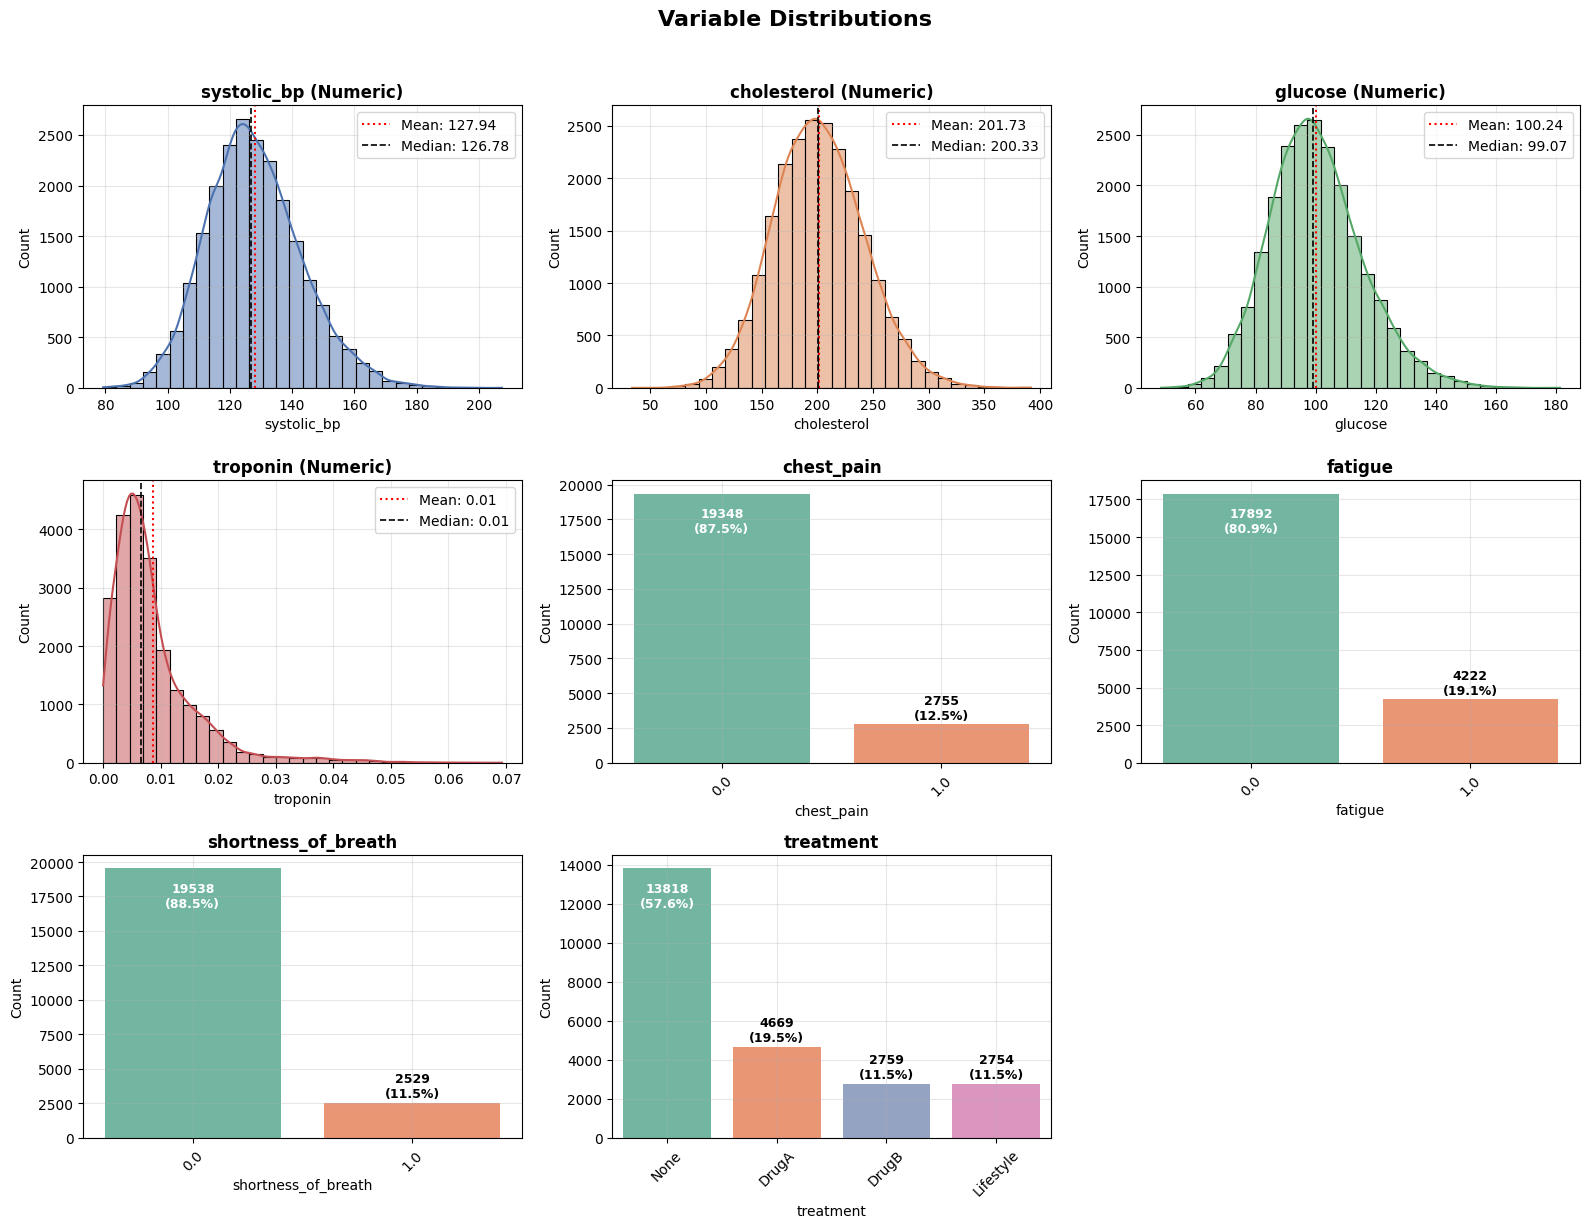


5. Missing values (after imputation):

✅ No missing values detected.


,patient_id,time,state,treatment,chest_pain,fatigue,shortness_of_breath,systolic_bp,cholesterol,glucose,troponin,utility
0,1,0,Early,DrugA,1.0,1.0,0.0,113.680,226.680,88.58,0.0139,0.449
1,1,1,Early,Lifestyle,0.0,1.0,0.0,130.600,226.680,112.56,0.0139,0.471
2,1,2,Early,None,0.0,0.0,0.0,165.780,146.180,95.92,0.0234,0.474
3,1,3,Early,DrugA,0.0,1.0,0.0,154.405,179.560,108.17,0.0141,0.450
4,1,4,Early,DrugA,0.0,0.0,0.0,143.030,196.565,97.01,0.0033,0.447
5,1,5,Early,None,0.0,1.0,1.0,148.430,213.570,85.85,0.0108,0.492
6,1,6,Early,DrugB,0.0,1.0,0.0,146.220,212.830,111.23,0.0096,0.393
7,1,7,Early,None,0.0,0.0,0.0,139.660,212.830,94.94,0.0069,0.500
8,2,0,Healthy,None,0.0,0.0,0.0,113.850,181.460,86.02,0.0037,1.000
9,2,1,Healthy,None,0.0,0.0,0.0,113.850,200.170,92.54,0.0098,1.000



6. Distributions for Selected Features (after imputation):



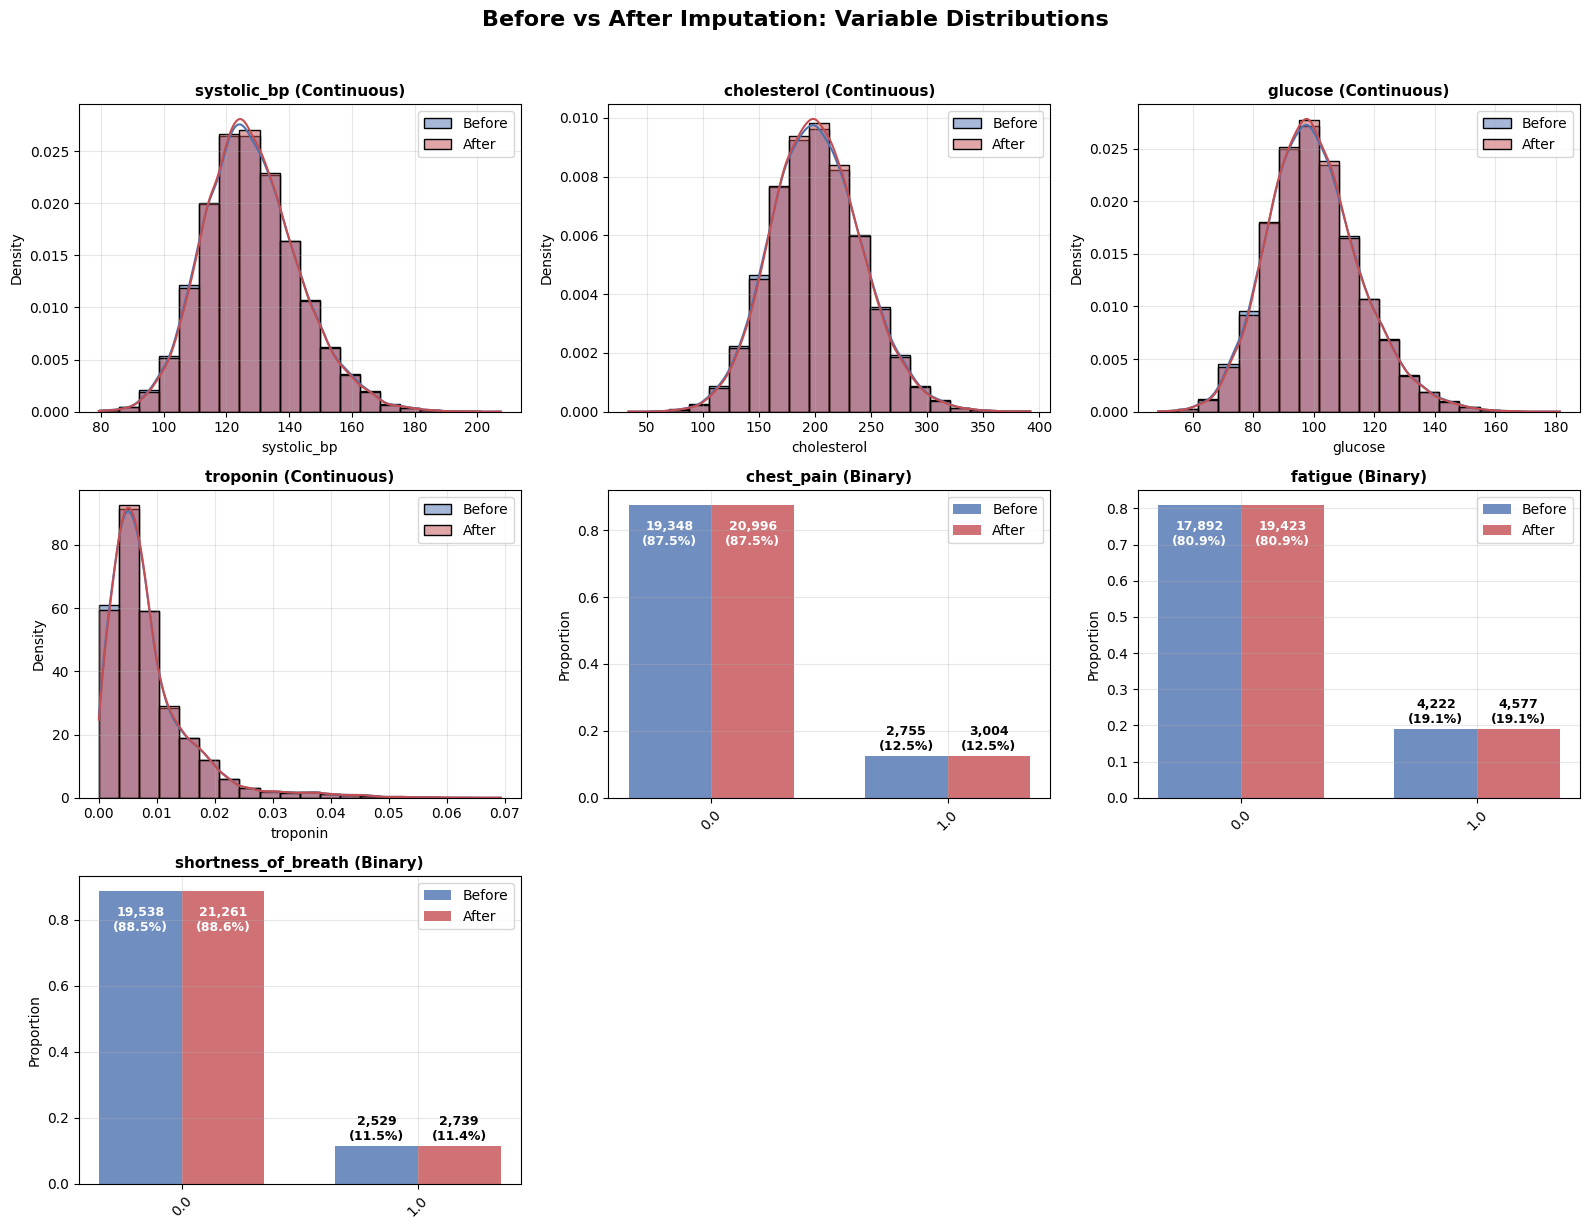

,Variable,Type,Test,Statistic,p-value,Significant Change
0,systolic_bp,Continuous,KS,0.004873,0.946178,False
1,cholesterol,Continuous,KS,0.005361,0.894174,False
2,glucose,Continuous,KS,0.005071,0.927693,False
3,troponin,Continuous,KS,0.005735,0.841996,False
4,chest_pain,Binary,Chi-square,0.024201,0.876374,False
5,fatigue,Binary,Chi-square,0.002104,0.963415,False
6,shortness_of_breath,Binary,Chi-square,0.021680,0.882940,False



7.1. Outlier check for Labs (continuous variable):

It would remove 1964 rows (8.18%)


,Variable,Outliers,Percent
0,systolic_bp,312,1.300000
1,cholesterol,247,1.029167
2,glucose,365,1.520833
3,troponin,1390,5.791667



7.2. Normality test for Labs (continuous variable):


systolic_bp:
  ✗ D’Agostino: Non-normal | Skewness: Symmetric (0.402) | Kurtosis: Mesokurtic (0.374)

cholesterol:
  ✗ D’Agostino: Non-normal | Skewness: Symmetric (0.221) | Kurtosis: Mesokurtic (0.248)

glucose:
  ✗ D’Agostino: Non-normal | Skewness: Symmetric (0.442) | Kurtosis: Mesokurtic (0.456)

troponin:
  ✗ D’Agostino: Non-normal | Skewness: right-skewed (2.280) | Kurtosis: Leptokurtic/peaked (7.384)


,Variable,Shapiro_Stat,Shapiro_p,DAgostino_Stat,DAgostino_p,Skewness,Kurtosis
0,systolic_bp,NaN,NaN,702.450958,2.915496e-153,0.402440,0.374093
1,cholesterol,NaN,NaN,240.938436,4.796047e-53,0.221373,0.248401
2,glucose,NaN,NaN,855.230341,1.945768e-186,0.441728,0.456081
3,troponin,NaN,NaN,11653.436319,0.000000e+00,2.279575,7.384219



8.1. Preprocessed dataset (first 10 rows):



,patient_id,time,state,treatment,utility,systolic_bp,cholesterol,glucose,troponin,chest_pain,fatigue,shortness_of_breath,treatment__DrugA,treatment__DrugB,treatment__Lifestyle,treatment__None
0,1,0,Early,DrugA,0.449,-0.943465,0.616542,-0.762314,0.709580,1.0,1.0,0.0,1,0,0,0
1,1,1,Early,Lifestyle,0.471,0.176214,0.616542,0.799786,0.709580,0.0,1.0,0.0,0,0,1,0
2,1,2,Early,None,0.474,2.504247,-1.376464,-0.284173,1.984382,0.0,0.0,0.0,0,0,0,1
3,1,3,Early,DrugA,0.450,1.751508,-0.550047,0.513814,0.736418,0.0,1.0,0.0,1,0,0,0
4,1,4,Early,DrugA,0.447,0.998768,-0.129040,-0.213169,-0.712830,0.0,0.0,0.0,1,0,0,0
5,1,5,Early,None,0.492,1.356113,0.291967,-0.940151,0.293592,0.0,1.0,1.0,0,0,0,1
6,1,6,Early,DrugB,0.393,1.209866,0.273646,0.713148,0.132565,0.0,1.0,0.0,0,1,0,0
7,1,7,Early,None,0.500,0.775759,0.273646,-0.348012,-0.229748,0.0,0.0,0.0,0,0,0,1
8,2,0,Healthy,None,1.000,-0.932216,-0.503007,-0.929077,-0.659155,0.0,0.0,0.0,0,0,0,1
9,2,1,Healthy,None,1.000,-0.932216,-0.039788,-0.504353,0.159403,0.0,0.0,0.0,0,0,0,1


8.2. Preprocessed features selected for clustering: ['systolic_bp', 'cholesterol', 'glucose', 'troponin', 'chest_pain', 'fatigue', 'shortness_of_breath', 'treatment__DrugA', 'treatment__DrugB', 'treatment__Lifestyle', 'treatment__None'] 


9. Correlation heatmap (with processed Features):



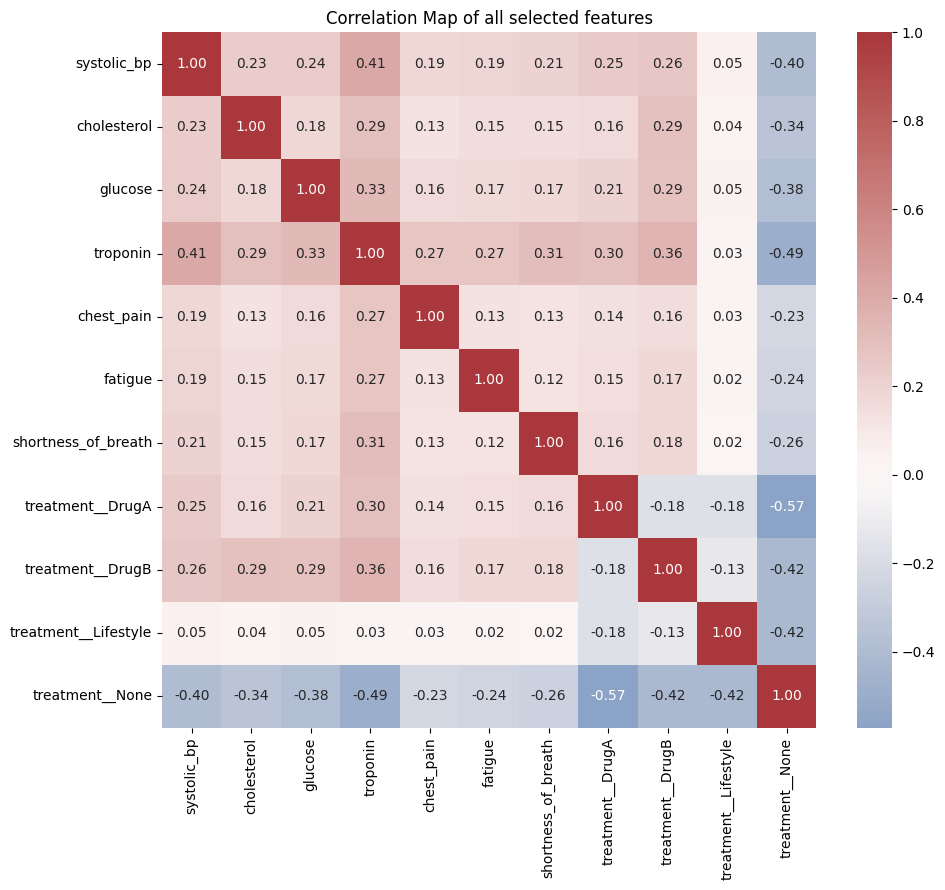

In [ ]:
# ---------- 1. Load dataset ----------
#Files must be in the same working directory
df_raw = pd.read_csv("encounters.csv", delimiter=';')
# Handle missing treatment values
df_raw['treatment'] = df_raw['treatment'].fillna('None')
print(f"1. Dataset loaded: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns\n")

# ---------- 2. Select features for clustering ----------
symptoms = ["chest_pain", "fatigue", "shortness_of_breath"]
treatment_var = ["treatment"]
labs = ["systolic_bp", "cholesterol", "glucose", "troponin"]
selected = symptoms + labs + treatment_var

print("2. Features selected for clustering:", selected, "\n")

# ---------- 3. Missing values before imputation ----------
print("3. Missing values (before imputation):\n")
display(summarize_missing(df_raw))

# ---------- 4. Visualize raw distributions ----------
print("\n4.Distributions for Selected Features (raw data):\n")
plot_distributions(df_raw, labs, symptoms, treatment_var)
#using the function like this we ignore_cols=["patient_id", "time", "utility", "state"]

# ---------- 5. Apply imputation strategy  ----------
df_transf = custom_impute(df_raw, labs, symptoms, col_to_group="patient_id")
print("\n5. Missing values (after imputation):\n")
summarize_missing(df_transf)
display(df_transf.head(10))

# ---------- 6. Compare distributions before vs after imputation ----------
print("\n6. Distributions for Selected Features (after imputation):\n")
display(compare_distributions(df_raw, df_transf, labs, symptoms))

# ---------- 7. Check outlier and test normality  ----------
print("\n7.1. Outlier check for Labs (continuous variable):\n")
display(detect_outliers(df_transf, labs))
print("\n7.2. Normality test for Labs (continuous variable):\n")
display(check_normality(df_transf, labs, verbose=True))

# ---------- 8. Preprocessing  ----------
df_processed, new_selected = preprocess_data(df_transf, labs, symptoms, treatment_var)
print("\n8.1. Preprocessed dataset (first 10 rows):\n")
display(df_processed.head(10))
print("8.2. Preprocessed features selected for clustering:", new_selected, "\n")

# ---------- 9. Correlation heatmap ----------
print("\n9. Correlation heatmap (with processed Features):\n")

# Now, the correlation matrix includes all the final columns
plt.figure(figsize=(10,9))
corr = df_processed[new_selected].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation Map of all selected features")
plt.tight_layout()
plt.show()

###2.1 Preprocessing Discussion


*   Function custom_imputation() applied per patient (groupby patient_id)

    Numeric columns →
    Replace NaN with the mean of the first and last available values

    Categorical/Binary columns →
    Replace NaN with the last available value

*   Correlation analysis

    The clinical lab variables (systolic_bp, cholesterol, glucose, troponin_log) show moderate and positive correlations with each other.
    
    The most notable and informative correlations involve the treatment variables, particularly "treatment_None" (indicating the absence of treatment).

    The symptoms (chest_pain, fatigue, shortness_of_breath) generally show weak correlations (close to zero) with most other variables.



###2.2 Normality Assessment Summary Report for GMM Suitability
This report interprets the normality test results to determine variable suitability for a Gaussian Mixture Model (GMM), which fundamentally requires variables to be approximately Gaussian (Normal).

1. Test Limitations:

The Shapiro-Wilk test is computationally limited and is skipped due to the very large sample size (n exceeds 5000). The D'Agostino-Pearson test is used instead as the primary formal test.

2. Analysis of systolic-bp, cholesterol and glucose:

Thesevariables are considered practically Gaussian and suitable for the GMM, even if the p-values reject this hypothesis. This is based on the fact that their Skewness and Kurtosis values are very close to zero, falling well within the ±0.5 range, which is accepted as the threshold for satisfying the relaxed normality requirements of the GMM.

3. Analysis of troponin:

Regarding the troponin variable, which is highly non-normal, the decision is still to include it in the model, assuming normality by further relaxing the GMM's assumptions. This choice is crucial to prevent the loss of significant data and information. The inclusion of troponin, alongside other binary variables (which are treated as numerical variables with values 0 and 1), helps to counterbalance the impact of non-normality, maximizing the informative use of the dataset.

---
##3.&nbsp;Model fitting

We fit a series of Gaussian Mixture Models (GMM) to the processed dataset to identify clusters in the data.  

- **Goal**: determine the optimal number of clusters.
- **Parameters tested**:
  - Number of components: 2–8
  - Covariance types: `full`, `tied`, `diag`, `spherical`
- **Model selection**: using AIC and BIC.

Fitting 28 GMM models...
Successfully fitted 28 models


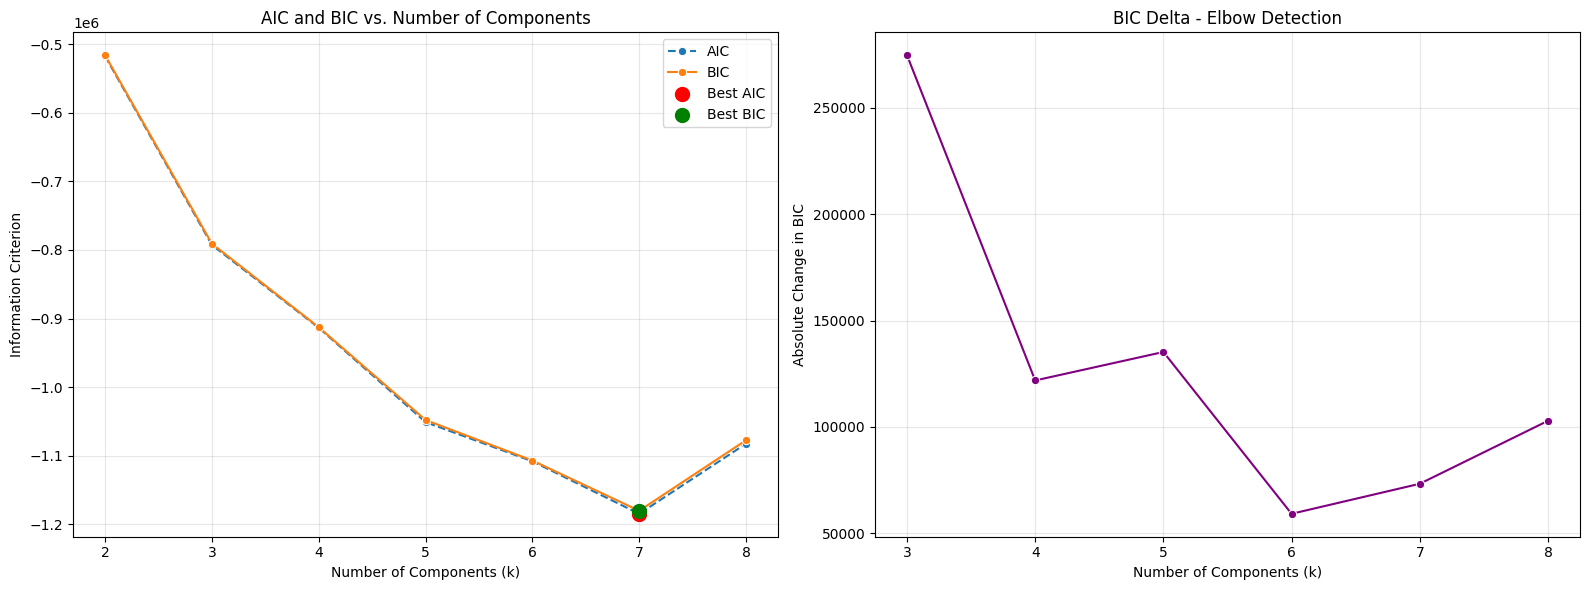


Best AIC: 7 components, full cov
Best BIC: 7 components, full cov


In [ ]:
# Fit a grid of GMM models
gmm_results = fit_gmm_grid(
    X=df_processed[new_selected].values,
    n_components_range=range(2, 9),
    covariance_types=['full', 'tied', 'diag', 'spherical']
)

# Plot model selection curves
best_aic, best_bic = plot_gmm_selection(gmm_results)

###3.1.&nbsp;Select a GMM

Based on the BIC/AIC criteria, we select a GMM model with the optimal number of components and covariance type.

* **Left Panel:** “AIC and BIC vs. Number of Components”:

  In the plot, both AIC and BIC decrease as the number of components increases (the model improves), but then they start to rise again.

  The minimum BIC (and AIC) occurs around k = 7.

* **Right Panel:** “BIC Delta – Elbow Detection":
  
  The y-axis shows the absolute change in BIC between consecutive numbers of components. A large drop means that adding a new cluster significantly improves the model.

  In the plot, the improvement in BIC decreases sharply up to k = 6, and then the changes between 6→7 and 7→8 are much smaller.

  So even though the lowest BIC is at 7, 6 clusters may provide a more balanced, parsimonious model


In [ ]:
# Fit the selected GMM
n_components_selected = best_bic['n_components']
cov_type_selected = best_bic['covariance_type']

gmm_model, cluster_labels = fit_gmm(
    X=df_processed[new_selected].values,
    n_components=n_components_selected,
    covariance_type=cov_type_selected
)

# Add cluster assignments to the dataframe
df_clusters = df_processed.copy()
df_clusters['Cluster'] = cluster_labels


Fitted GMM: 7 components, full covariance
Cluster distribution:
0    11137
1      642
2     7428
3       60
4     3352
5      768
6      613
Name: count, dtype: int64


### 3.2. Cluster Visualization

To explore the structure of the identified clusters, we project the high-dimensional feature space into two dimensions using **Principal Component Analysis (PCA)** or **Factor Analysis of Mixed Data (FAMD)** for mixed continuous and binary variables.

This visualization allows us to assess the **spatial separation** and **cohesion** of clusters, providing an intuitive view of how well the GMM captures distinct subgroups within the dataset.


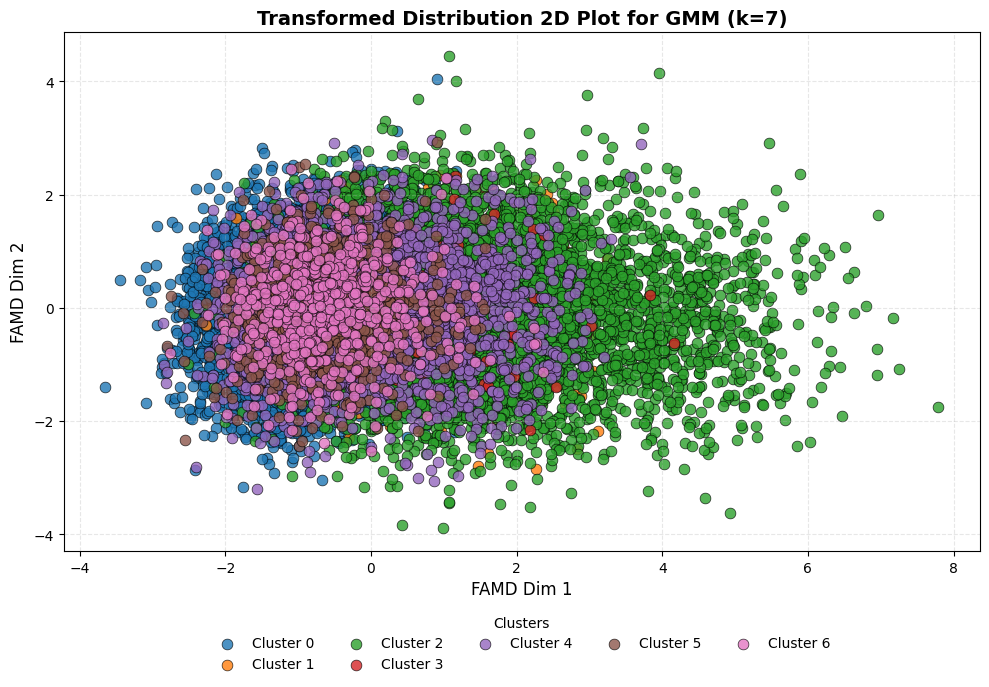

In [ ]:
plot_clusters_2D(X=df_processed[new_selected].values, binary_features = symptoms,
                 title = f"Transformed Distribution 2D Plot for GMM (k={n_components_selected})",
                 labels=cluster_labels,feature_names=new_selected)

### 3.3.&nbsp;Cluster Evaluation

We performed a comprehensive evaluation of the clustering quality using both **global metrics** and **feature-level statistical tests**.

**Global Cluster Quality Metrics**  
To assess the overall separation and compactness of the Gaussian Mixture Model (GMM) clusters, we computed:

- **Silhouette Score** — Measures how similar each point is to its own cluster compared to other clusters (higher is better).  
- **Calinski–Harabasz Index** — Ratio of between-cluster dispersion to within-cluster dispersion (higher indicates better-defined clusters).  
- **Davies–Bouldin Index** — Average similarity between clusters, where lower values indicate better separation.

These metrics quantify the **global structure** and **stability** of the GMM partitioning.

**Feature-Level Statistical Evaluation**  
Beyond global structure, we also evaluated whether **continuous features differ significantly across clusters**:

- Performed **ANOVA F-tests** for each numeric variable across clusters.  
- Computed **effect sizes (η²)** to measure the magnitude of between-cluster differences.  
- Conducted **pairwise post-hoc comparisons** (with Bonferroni correction) to identify which cluster pairs differ significantly.  
- Visualized these distributions using **boxplots** (for continuous features) and **stacked barplots** (for binary or one-hot features).

This combined approach provides a **comprehensive understanding** of both the global cluster quality and the **feature-level distinctiveness** driving cluster separation.


In [ ]:
# Ensure cluster labels are sorted numerically
sorted_clusters = np.sort(np.unique(cluster_labels))
mapping = {old: new for new, old in enumerate(sorted_clusters)}
cluster_labels_sorted = np.array([mapping[label] for label in cluster_labels])
binary_features=[f for f in new_selected if f not in labs]

# Compute cluster metrics on sorted labels
metrics, anova_results, pairwise_results = calculate_cluster_metrics(
    df_processed[new_selected].values, cluster_labels_sorted, new_selected,
    binary_features=binary_features,return_pairwise=True
)

print("Significance test:\n")
metrics = pd.DataFrame(metrics, index=[0])
anova_results = pd.DataFrame(anova_results)

display(metrics, anova_results)
#print(pairwise_results)

Significance test:



,silhouette,calinski_harabasz,davies_bouldin,n_clusters,n_samples
0,0.055183,1357.219569,3.508944,7,24000


,systolic_bp,cholesterol,glucose,troponin,chest_pain,fatigue,shortness_of_breath,treatment__DrugA,treatment__DrugB,treatment__Lifestyle,treatment__None
test,anova,anova,anova,anova,chi2,chi2,chi2,chi2,chi2,chi2,chi2
F,858.080447,600.276588,764.742578,1532.409116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
statistic,NaN,NaN,NaN,NaN,9760.638663,5943.013058,9073.475104,12932.539822,6954.901968,16165.738403,20741.926322
dof,NaN,NaN,NaN,NaN,6,6,6,6,6,6,6


### 3.2.&nbsp;Cluster Characterization

To better understand the composition of each cluster, we analyze the distributions of laboratory, symptom, and treatment features:

- **Continuous features** are visualized using **boxplots** to highlight differences in central tendency and variability.  
- **Binary features** are visualized using **proportion bar plots** to show the prevalence of symptoms within clusters.  
- **Categorical features**, such as treatment type, were transformed through **one-hot encoding** and visualized as **stacked bar plots of proportions** to capture the relative frequency of each intervention.  
- **Pairwise comparisons** identify statistically significant differences between clusters, providing insight into which features most strongly drive separation.  

This approach enables a comprehensive view of cluster profiles and facilitates interpretation relative to known disease states (Healthy, Early, Advanced).



Collection of heatmaps that describe the signicant differences between clusters for each selected feature:



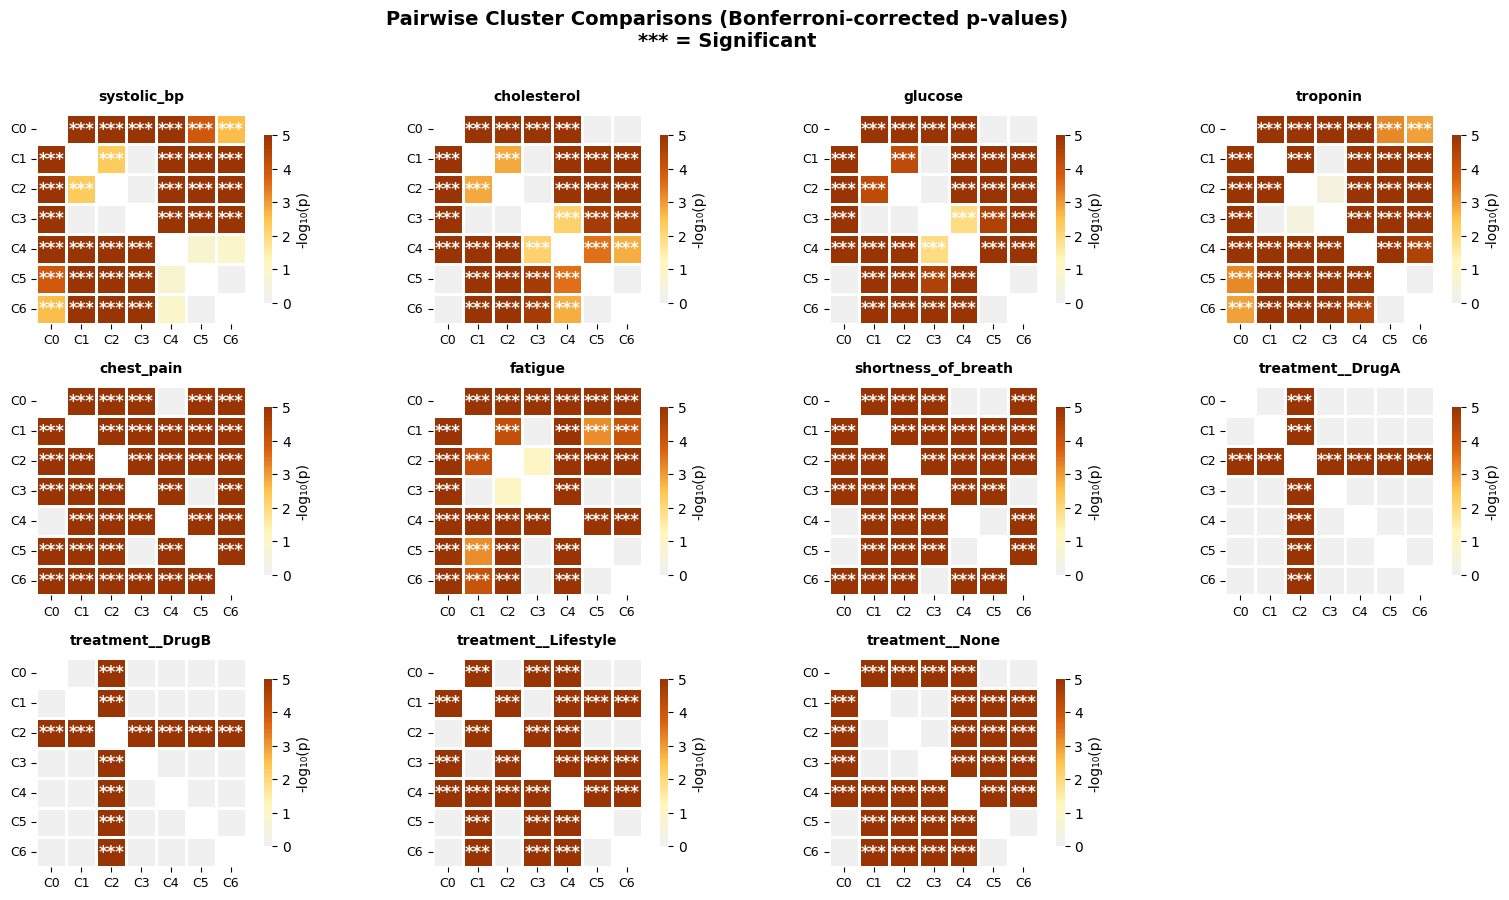


Overall significantly diferent number of Features per pair of clusters:
Note: there were 11 selected features, being 4 of them the used treatment.


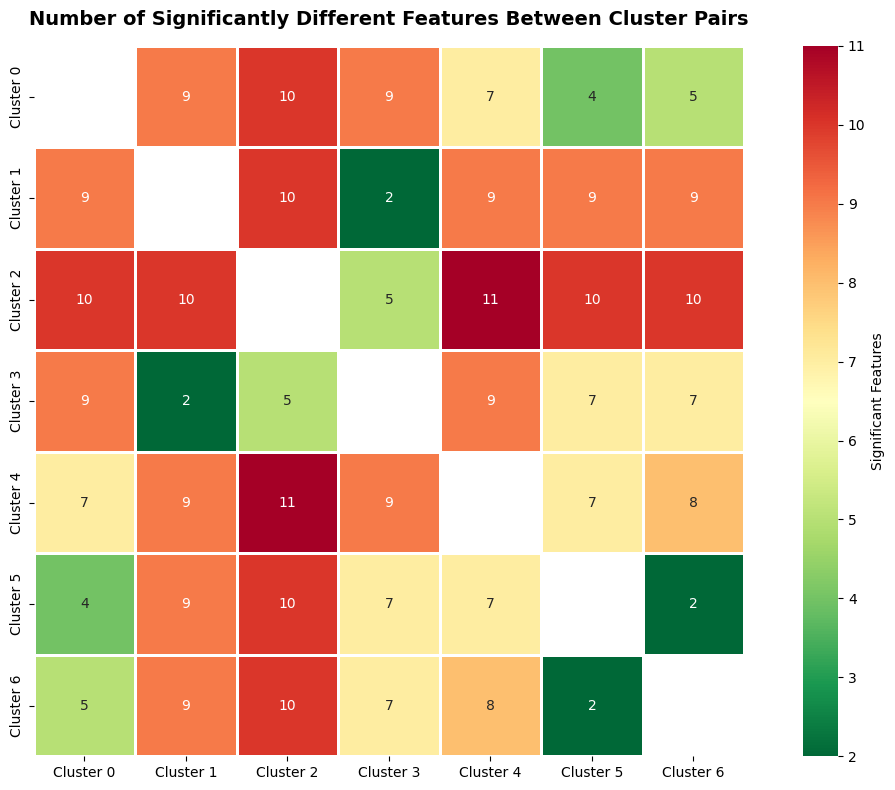


Feature distributions per cluster:



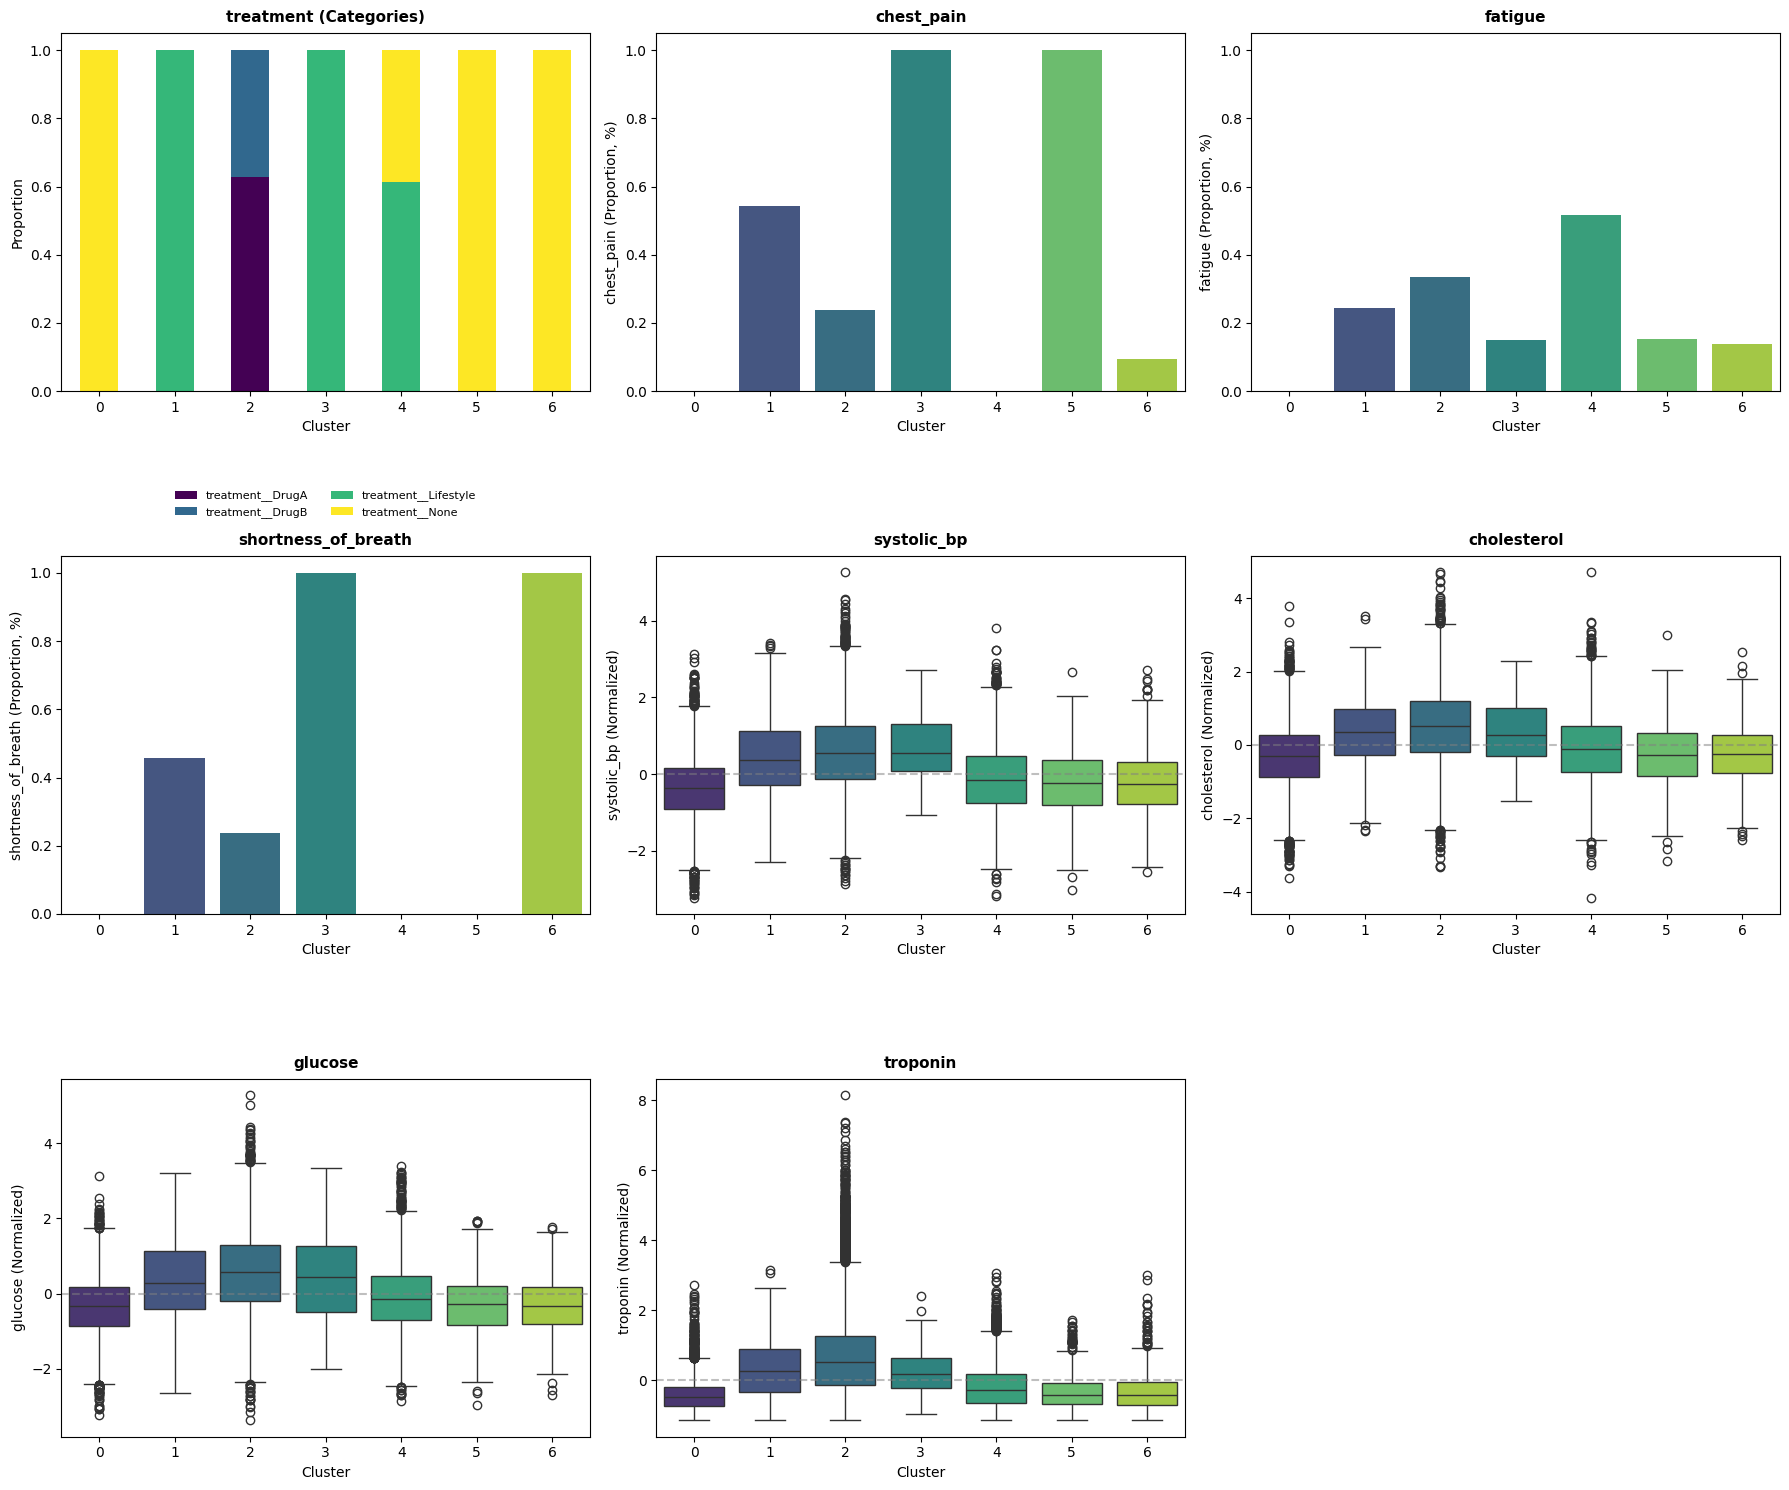

In [ ]:
#Plot pairwise data
print("Collection of heatmaps that describe the signicant differences between clusters for each selected feature:\n")
plot_pairwise_heatmaps(pairwise_results, feature_names=new_selected)
print(f"\nOverall significantly diferent number of Features per pair of clusters:\nNote: there were {len(new_selected)} selected features, being 4 of them the used treatment.")
plot_pairwise_significance_matrix(pairwise_results, method='count')

# Visualize cluster profiles
print("\nFeature distributions per cluster:\n")
plot_cluster_profiles(
    X=df_processed[new_selected].values,
    labels=cluster_labels,
    feature_names=new_selected,
    binary_features=binary_features)

**Discussion:**  

The cluster characterization reveals **clear differentiation** among clusters based on both continuous and binary features.  
Pairwise significance analysis highlights which cluster comparisons are statistically robust, identifying key drivers of separation between groups.  

Notable observations include:  
- **(4, 2):** all selected features show significant differences.  
- **(2, (0, 1, 5, or 6)):** around 10 features are significantly different.  
- **(0, (1 or 3))**, **(1, (4, 5, or 6))**, and **(3, 4):** 9 features differ significantly.  
- **(1, 3)** and **(5, 6):** only 2 significantly different features.  
- Other pairs range between 4 and 8 significantly different features.  

Overall, these analyses confirm the **internal validity** of the clustering model and enhance interpretability, linking each cluster to potential clinical phenotypes or disease stages.

---

**Feature-by-Feature Interpretation**

**Treatment (One-Hot):**
- Clusters **1** and **3**: dominated by **Lifestyle** interventions.  
- Cluster **2**: strong presence of **DrugB** (~ 60%), compared to **DrugA** (~ 40%).
- Cluster **0, 5 and 6**: predominantly **no treatment**.

**Shortness of Breath:**  
- Present in clusters **1-3 and 6**, particularly **3 and 6**.  

**Fatigue:**  
- Most prevalent in clusters **2 and 4**, not present in cluster **0**.  

**Chest Pain:**  
- Prominent in clusters **3 and 5**, not present in cluster **0 and 4**.  

**Systolic Blood Pressure:**  
- Elevated in cluster **1-3**, spcially cluster **3** with the highest medean BP value; clusters **4-6 and 0** have normalized medean values lower than 0.  

**Cholesterol:**  
- Elevated in clusters **1–3**, higher in cluster **2**, lower in **4–6 and 0**.  

**Glucose:**  
- Mirrors cholesterol pattern.  

**Troponin:**  
- Mirrors cholesterol pattern.

---

### **Cluster Summary**

| **Cluster** | **Biochemical Values** | **Symptoms** | **Treatment** | **Overall Profile** |
|:------------:|:-----------------------|:--------------|:---------------|:--------------------|
| **0** | Normal biomarker levels (baseline) | Asymptomatic | None | **Healthy baseline** |
| **1** | Elevated biomarkers (BP, cholesterol, glucose) | Mildly symptomatic | Lifestyle | **Moderate-risk** |
| **2** | Highest metabolic markers (cholesterol, glucose, troponin) | Highly symptomatic | Predominantly **DrugB** | **High-risk** |
| **3** | Elevated biomarkers | Strong symptoms (chest pain, shortness of breath) | Lifestyle | **Moderate–high-risk** |
| **4** | Normalized BP, low cholesterol | Moderate fatigue | None | **Mild-risk** |
| **5** | Normal biochemical values | Chest pain dominant, otherwise mild | Untreated | **Transient symptom group** |
| **6** | Normal biochemical values | Shortness of breath dominant, otherwise mild | None | **Transient symptom group** |

---

</br>These findings indicate that the clustering model effectively distinguishes **symptomatic vs. asymptomatic** patient subgroups, reflecting progressive **cardiometabolic risk and disease severity**.  
Clusters **1–3** capture **metabolically active, symptomatic** groups, while clusters **4–6** correspond to **low-risk or healthy** populations — supporting the model’s **clinical interpretability and robustness**.  

---

### 3.4. &nbsp;Comparison to True Disease States

After clustering, it is important to assess how well the discovered groups correspond to the **known disease states**.  
We use **cluster alignment metrics** and **purity tables** to evaluate this correspondence quantitatively.  

Specifically, we compute:

- **Cluster Purity** (row-normalized) — shows the proportion of each true disease state within each cluster.
- **Adjusted Rand Index (ARI)** — measures the similarity between cluster assignments and true labels, **adjusted for chance**.  
  - ARI ranges from **-1 to 1**:  
    - **1**: perfect match  
    - **0**: random assignment  
    - **<0**: less agreement than random  
- **Normalized Mutual Information (NMI)** — quantifies the amount of information shared between cluster assignments and true labels.  
  - NMI ranges from **0 to 1**:  
    - **1**: perfect agreement  
    - **0**: no mutual information  








CLUSTER ALIGNMENT (7-component)

--- Cluster Purity (Row-Normalized) ---
state   Advanced   Early Healthy
Cluster                         
0          0.00%   2.46%  97.54%
1          0.00%  85.05%  14.95%
2         15.81%  73.48%  10.72%
3          0.00%  91.67%   8.33%
4          0.00%  32.28%  67.72%
5          0.00%  16.93%  83.07%
6          0.00%  17.94%  82.06%

--- Alignment Metrics ---
Adjusted Rand Index (ARI): 0.4196
Normalized Mutual Information (NMI): 0.3671

Interpretation: ○ Moderate alignment: Partial correspondence


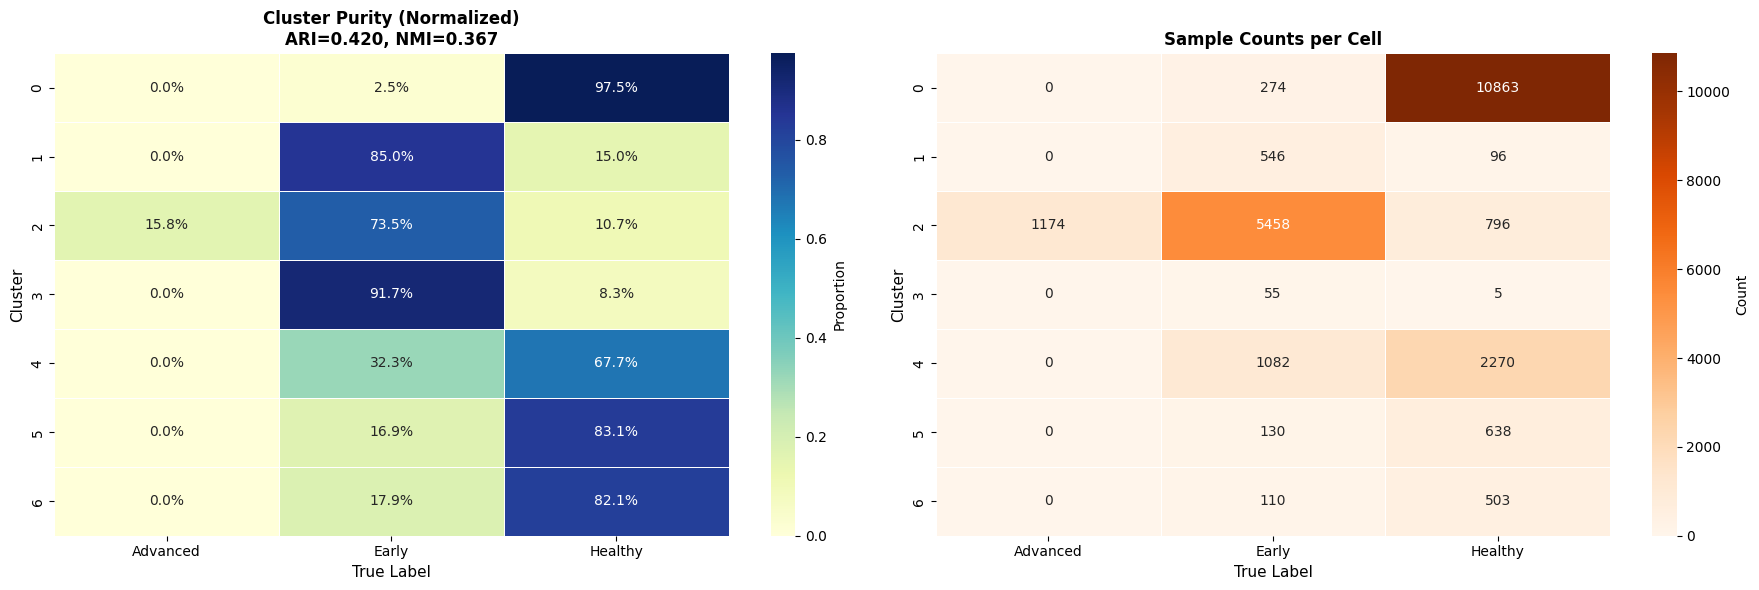

In [ ]:
_,_,_ = cluster_alignment_analysis(df_clusters, 'state', 'Cluster')

**Discussion:**  

The 7-component GMM shows **moderate alignment** with the true disease states:

- Clusters capture **distinct subgroups**, but some clusters mix multiple states (e.g., Cluster 2 contains a mix of Early and Advanced cases).  
- The **ARI (0.420)** and **NMI (0.367)** indicate partial correspondence, suggesting that the model captures meaningful structure but does not perfectly recover the true states.  
- Certain clusters (e.g., Cluster 1 and Cluster 3) are **highly enriched** for the Early state, highlighting potential areas where the model successfully identifies homogeneous subgroups.  

Overall, the clustering provides **useful insights into disease patterns**, though some misalignment is expected due to **overlapping clinical features** across disease states.

---
### 3.5. Optional: Compare Multiple GMM Models

In this section, we extend the analysis by fitting and comparing multiple Gaussian Mixture Models (GMMs) with different numbers of components (e.g., *k = 6* vs *k = 7*).  
This comparison helps assess **model stability, interpretability, and feature-level consistency** across different granularities of clustering.

We perform a **side-by-side evaluation** that includes:
- **Cluster distributions** — to visualize how data points are reassigned across models.  
- **Feature-level statistics** — using ANOVA (for continuous features) and chi-square tests (for binary/categorical features).  
- **Effect sizes (η²)** — to quantify each feature’s discriminative power under each model.  
- **Alignment metrics** — Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) to assess how well cluster assignments correspond to the true states.  

This enables a data-driven decision about which GMM configuration provides the best trade-off between **statistical separation** and **real-world interpretability**, forming a **one-stop GMM comparison & reporting tool.**


Fitted GMM: 7 components, full covariance
Cluster distribution:
0    11137
1      642
2     7428
3       60
4     3352
5      768
6      613
Name: count, dtype: int64
Fitted GMM: 6 components, full covariance
Cluster distribution:
0     2052
1      446
2     7428
3      256
4    12437
5     1381
Name: count, dtype: int64

GMM MODEL COMPARISON: GMM (k=7) vs GMM (k=6)

--- Feature-Level Statistics ---
             Feature       Type  Stat_GMM (k=7)  p_GMM (k=7)  Eta2_GMM (k=7)  Stat_GMM (k=6)  p_GMM (k=6)  Eta2_GMM (k=6) Better_Model     Eta2_Diff
         systolic_bp Continuous      858.080447          0.0        0.176672     1063.120259          0.0        0.181360    GMM (k=6) -4.688456e-03
         cholesterol Continuous      600.276588          0.0        0.130520      742.200079          0.0        0.133947    GMM (k=6) -3.426788e-03
             glucose Continuous      764.742578          0.0        0.160540      944.432211          0.0        0.164443    GMM (k=6) -3.903029e-03
 

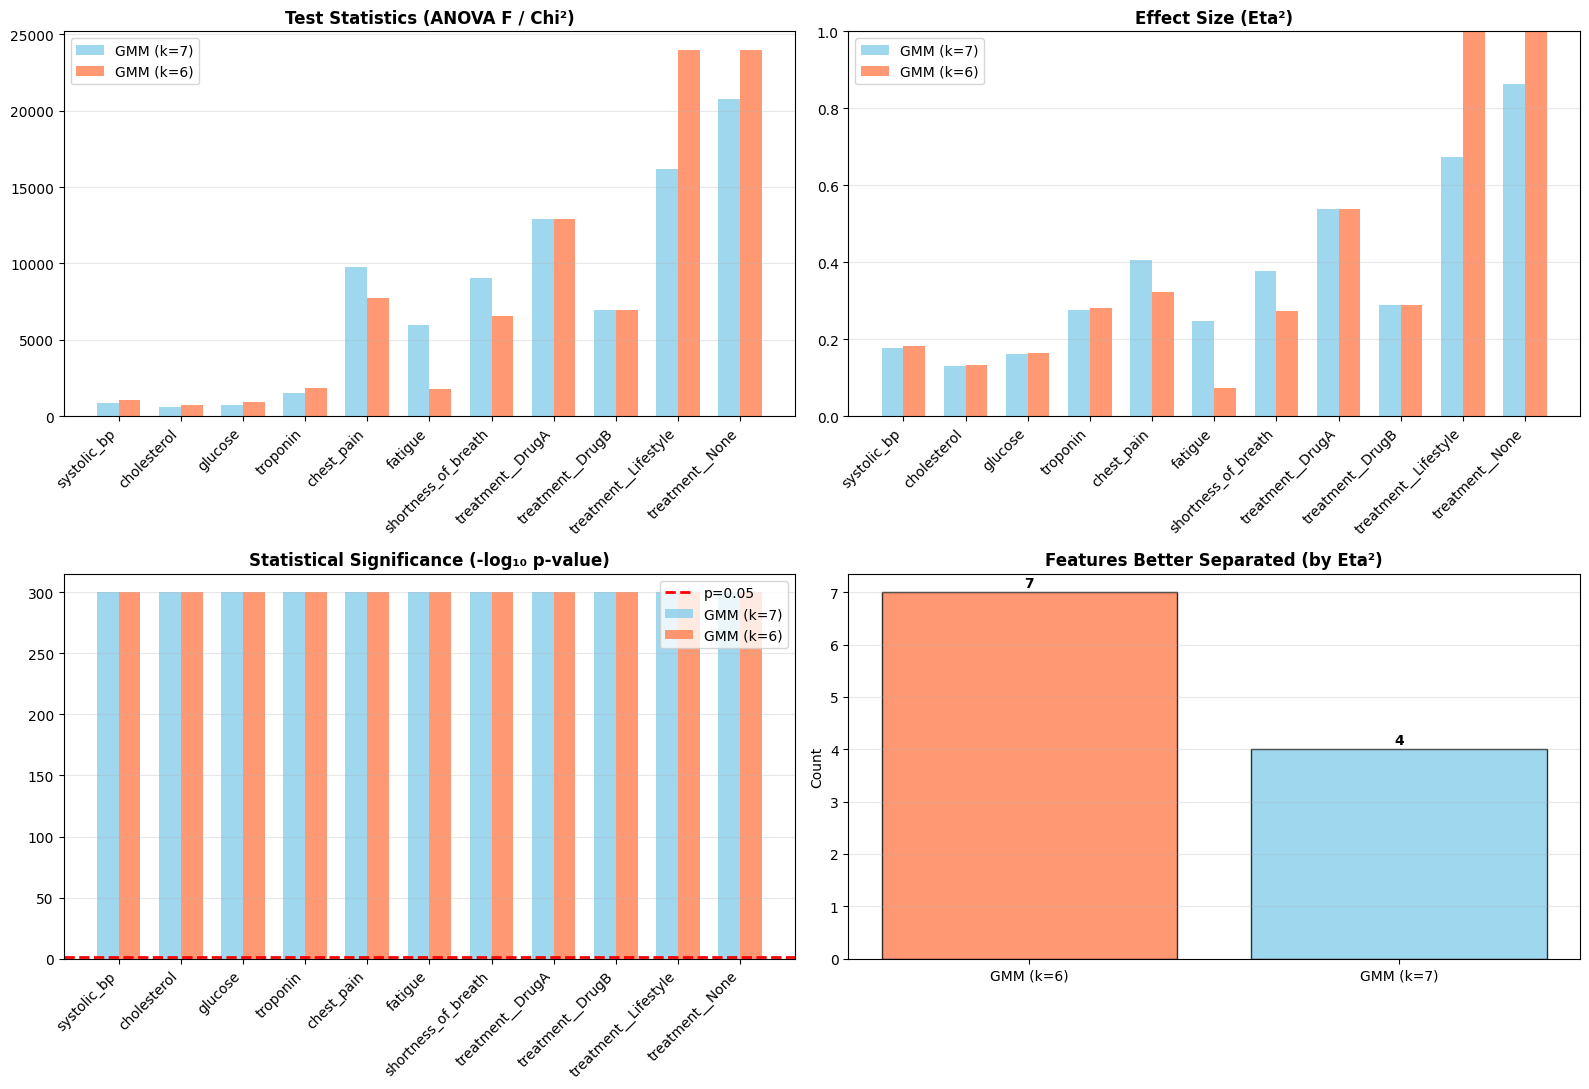

In [ ]:
gmm1_Ncomponents=n_components_selected
gmm2_Ncomponents=6
gmm1, labels_gmm_1 = fit_gmm(
    X=df_processed[new_selected].values,
    n_components=n_components_selected,
    covariance_type=cov_type_selected
)

gmm2, labels_gmm_2 = fit_gmm(
    X=df_processed[new_selected].values,
    n_components=gmm2_Ncomponents,
    covariance_type=cov_type_selected
)

comparison_df, cluster_stats, alignment_metrics = compare_two_gmm_models(
    df_processed[new_selected],
    labels_gmm1=labels_gmm_1,
    labels_gmm2=labels_gmm_2,
    feature_names=new_selected,
    binary_features=binary_features,
    true_labels=df_processed['state'],
    gmm1_name="GMM (k=7)",
    gmm2_name="GMM (k=6)",
)



Results: GMM (k = 7) vs GMM (k = 6)

After fitting both models, we obtain:

- **Cluster Distributions:**
  - GMM (k = 7): 7 clusters, varied sizes (from small rare groups to large dominant ones).  
  - GMM (k = 6): slightly more balanced distribution.

- **Feature-Level Insights:**  
  The table and plots above summarizes ANOVA / chi-square results, p-values, and η² for each feature under both models, along with which model better explains feature variance.

- **Model Performance Summary:**  
  Overall alignment with the true labels was higher for **GMM (k = 6)** (ARI = 0.498 | NMI = 0.398) compared to **GMM (k = 7)** (ARI = 0.420 | NMI = 0.367).

---

> **Comment:**  
> The GMM with **6 components** provides stronger alignment with true states and slightly better overall feature discrimination.  
> However, the **7-component model** may offer finer granularity for subgroup discovery (notably in binary symptom variables like *fatigue* and *shortness of breath*).  
> The optimal model choice should balance **statistical strength** with **domain interpretability**, depending on the clinical or analytical goal.